In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
cd ..

/home/pierre/git/bo-on-graph


In [2]:
import os
import torch
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
plt.rcParams['text.usetex'] = True
matplotlib.rcParams.update({'font.size': 18})
supported_labels = [
    "random",
    "local_search",
    "ei",
    "ei_ego_network_1",
    "ei_ego_network_1_old",
    "dfs",
    "bfs",
    "ei_ego_network_2",
    "ei_ego_network_2_no_ard",
    "ei_ego_network_matern",
]
# cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']))
d_color = {"ei_ego_network_1":"#1f77b4", "ei_ego_network_2":"#8c564b", "random":"#ff7f0e",
           "local_search":"#2ca02c", "dfs": "#d62728", "bfs": "#9467bd", "ei_ego_network_1_old":"#e377c2",
           "ei_ego_network_2_no_ard":"#7f7f7f", "ei_ego_network_matern":'#bcbd22'}
d_label = {"ei_ego_network_1":"BO_Poly", "ei_ego_network_1_old":"BO_SumInverse",
           "ei_ego_network_2":"BO_Diff_ARD", "ei_ego_network_2_no_ard":"BO_Diff", 
           "random":"Random", "local_search":"Local search", "dfs": "Dfs", "bfs": "Bfs",
           "ei_ego_network_matern":"BO_Matern"}



In [3]:
def plot_result(ax, path: str, label: str, plot_kwargs: dict = None, median=False, std=False, cumulative=True, regret=True):
    # path: main directory of experiments (eg. logs/centrality), label : label experiment to plot
    exp_dir = os.path.join(path, label)
    algorithm_name = [name for name in os.listdir(exp_dir) if os.path.isdir(os.path.join(exp_dir, name))]
    min_max_len = np.inf
    for algorithm in algorithm_name:
        alg_dir = os.path.join(exp_dir, algorithm)
        ## Here are in directory with signal png and pt
        plot_kwargs = deepcopy(plot_kwargs) or {}
        data_path_seeds = [f for f in os.listdir(alg_dir) if ".pt" in f]
        data_over_seeds = []
        for i, df in enumerate(data_path_seeds):
            data_path = os.path.join(alg_dir, df)
            with open(data_path, "rb") as fp:
                data = torch.load(data_path, map_location="cpu")
                minimize = False
            if "regret" in data.keys() and regret:
                y = -data["regret"].numpy().flatten()   # to maximize negative regret
                minimize = True
            else:
                assert "Y" in data.keys()
                y = data["Y"].numpy().flatten()
            data_over_seeds.append(y)
        n_data_per_trial = np.array([len(d) for d in data_over_seeds])
        max_len = max(n_data_per_trial)
        if len(np.unique(n_data_per_trial)) > 1:
            # pad as appropriate
            for i, d in enumerate(data_over_seeds):
                data_over_seeds[i] = np.concatenate((
                    d, d[-1] * np.ones(max_len - d.shape[0])))
        all_data = np.array(data_over_seeds)
        if cumulative:
            y = pd.DataFrame(all_data).cummax(axis=1)
        else:
            y = pd.DataFrame(all_data)
        x = np.arange(all_data.shape[1])
        if median:
            mean = y.median(axis=0)
            lb = y.quantile(q=0.25, axis=0)
            ub = y.quantile(q=0.75, axis=0)
        elif std:
            mean = y.mean(axis=0)
            # standard error
            lb = mean - y.std(axis=0)
            ub = mean + y.std(axis=0)
        else:
            mean = y.mean(axis=0)
            # standard error
            lb = mean - y.std(axis=0) / np.sqrt(all_data.shape[0])
            ub = mean + y.std(axis=0) / np.sqrt(all_data.shape[0])
        if minimize:
            mean = -mean
            lb = -lb
            ub = -ub
        ax.plot(x, mean, ".-", label=d_label[algorithm], color=d_color[algorithm], **plot_kwargs)
        if "alpha" in plot_kwargs.keys():
            del plot_kwargs["alpha"]
        if "markevery" in plot_kwargs.keys():
            del plot_kwargs["markevery"]
        ax.fill_between(x, lb, ub, alpha=0.1, color=d_color[algorithm], **plot_kwargs)
        min_max_len = min(min_max_len, max_len)
    #ax.legend()
    ax.set_xlabel(r"\#Iters")
    ax.set_ylabel("Regret")
    ax.set_xlim([0, min_max_len])
    ax.grid()
    #plt.yscale("log")
    
    #plt.savefig(os.path.join(exp_dir, "plot_result_regretpng.png"), bbox_inches='tight')
    #plt.savefig(os.path.join(exp_dir, "plot_result_regretpdf.pdf"), bbox_inches='tight')
    #plt.clf()
    #return y, max_len

# BA Graph Centrality

0 0
0 1
0 2
1 0
1 1
1 2


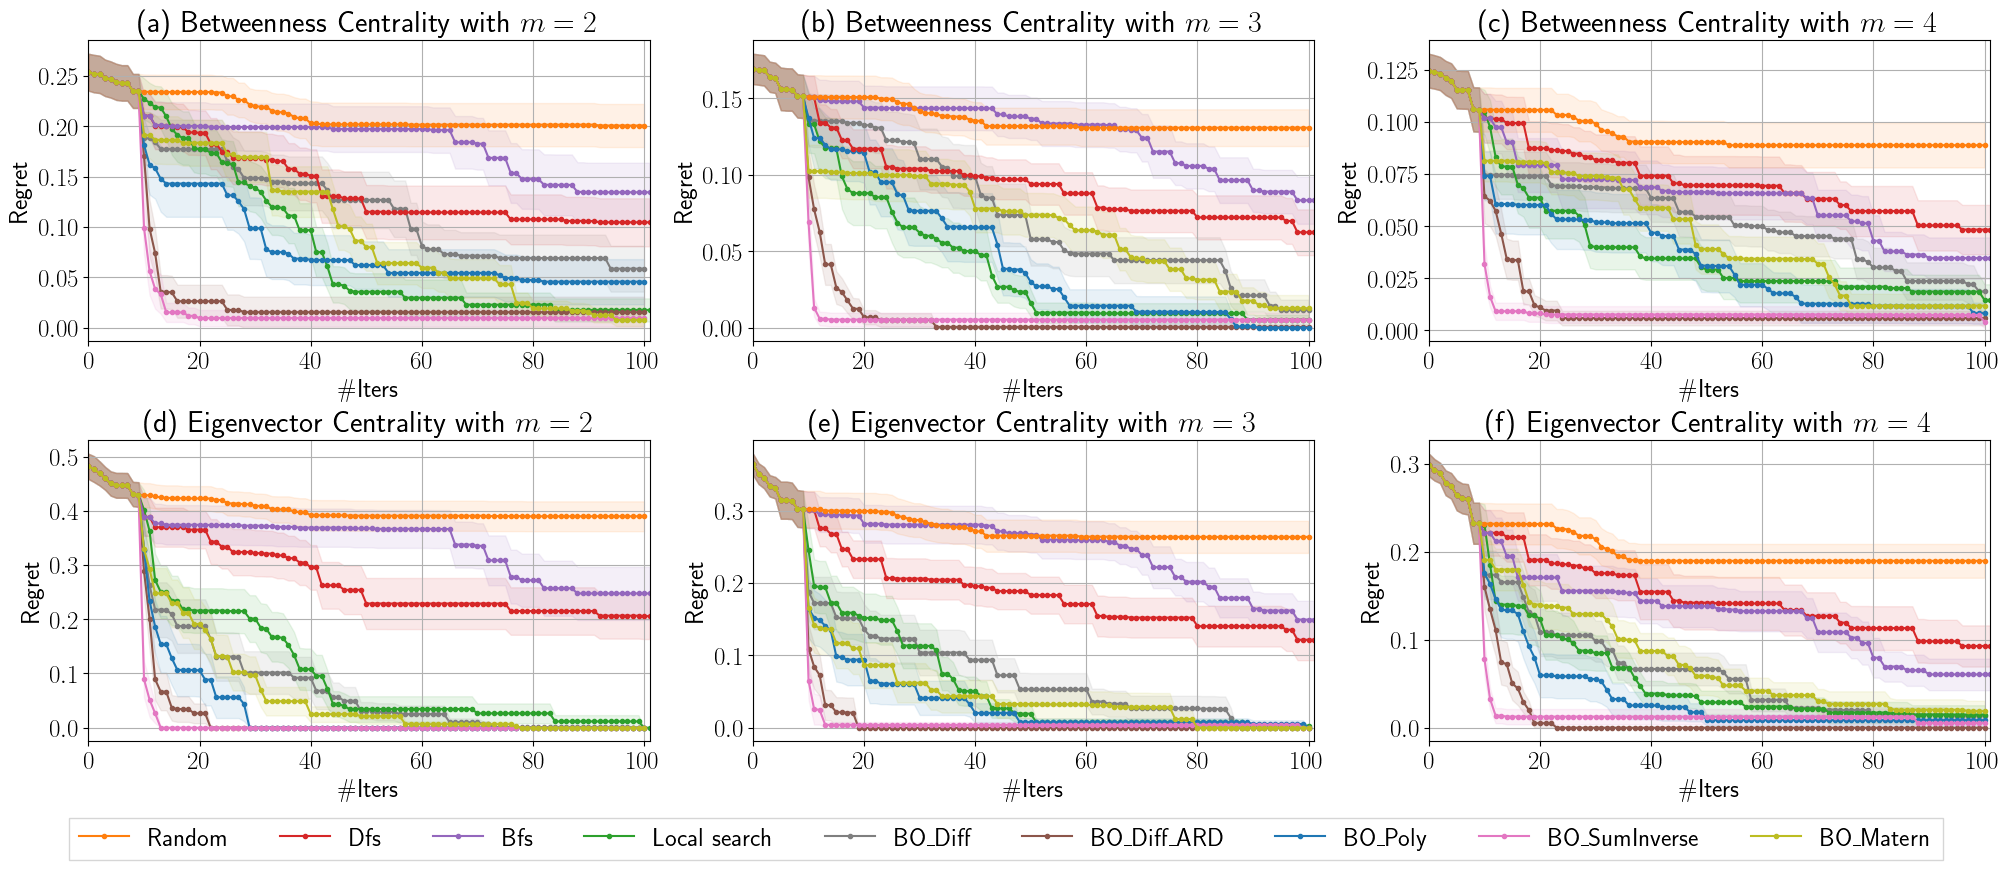

In [4]:
list_experiences = ["ba_betweenness_m-2_ninit-20_n-1000", "ba_betweenness_m-3_ninit-20_n-1000", "ba_betweenness_m-4_ninit-20_n-1000",
                    "ba_eigenvector_centrality_m-2_ninit-20_n-1000", "ba_eigenvector_centrality_m-3_ninit-20_n-1000", "ba_eigenvector_centrality_m-4_ninit-20_n-1000"]
n_rows, n_cols = 2, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_row, idx_col], "./logs/centrality/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [6, 4, 5, 1, 0, 2, 3, 7, 8]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('(a) Betweenness Centrality with ' + r'$m = 2$')
axs[0, 1].title.set_text('(b) Betweenness Centrality with ' + r'$m = 3$')
axs[0, 2].title.set_text('(c) Betweenness Centrality with ' + r'$m = 4$')
axs[1, 0].title.set_text('(d) Eigenvector Centrality with ' + r'$m = 2$')
axs[1, 1].title.set_text('(e) Eigenvector Centrality with ' + r'$m = 3$')
axs[1, 2].title.set_text('(f) Eigenvector Centrality with ' + r'$m = 4$')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9)
#plt.legend()
#plt.show()
plt.savefig("centrality_ba.pdf", bbox_inches='tight')

# WS Graph Centrality

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3


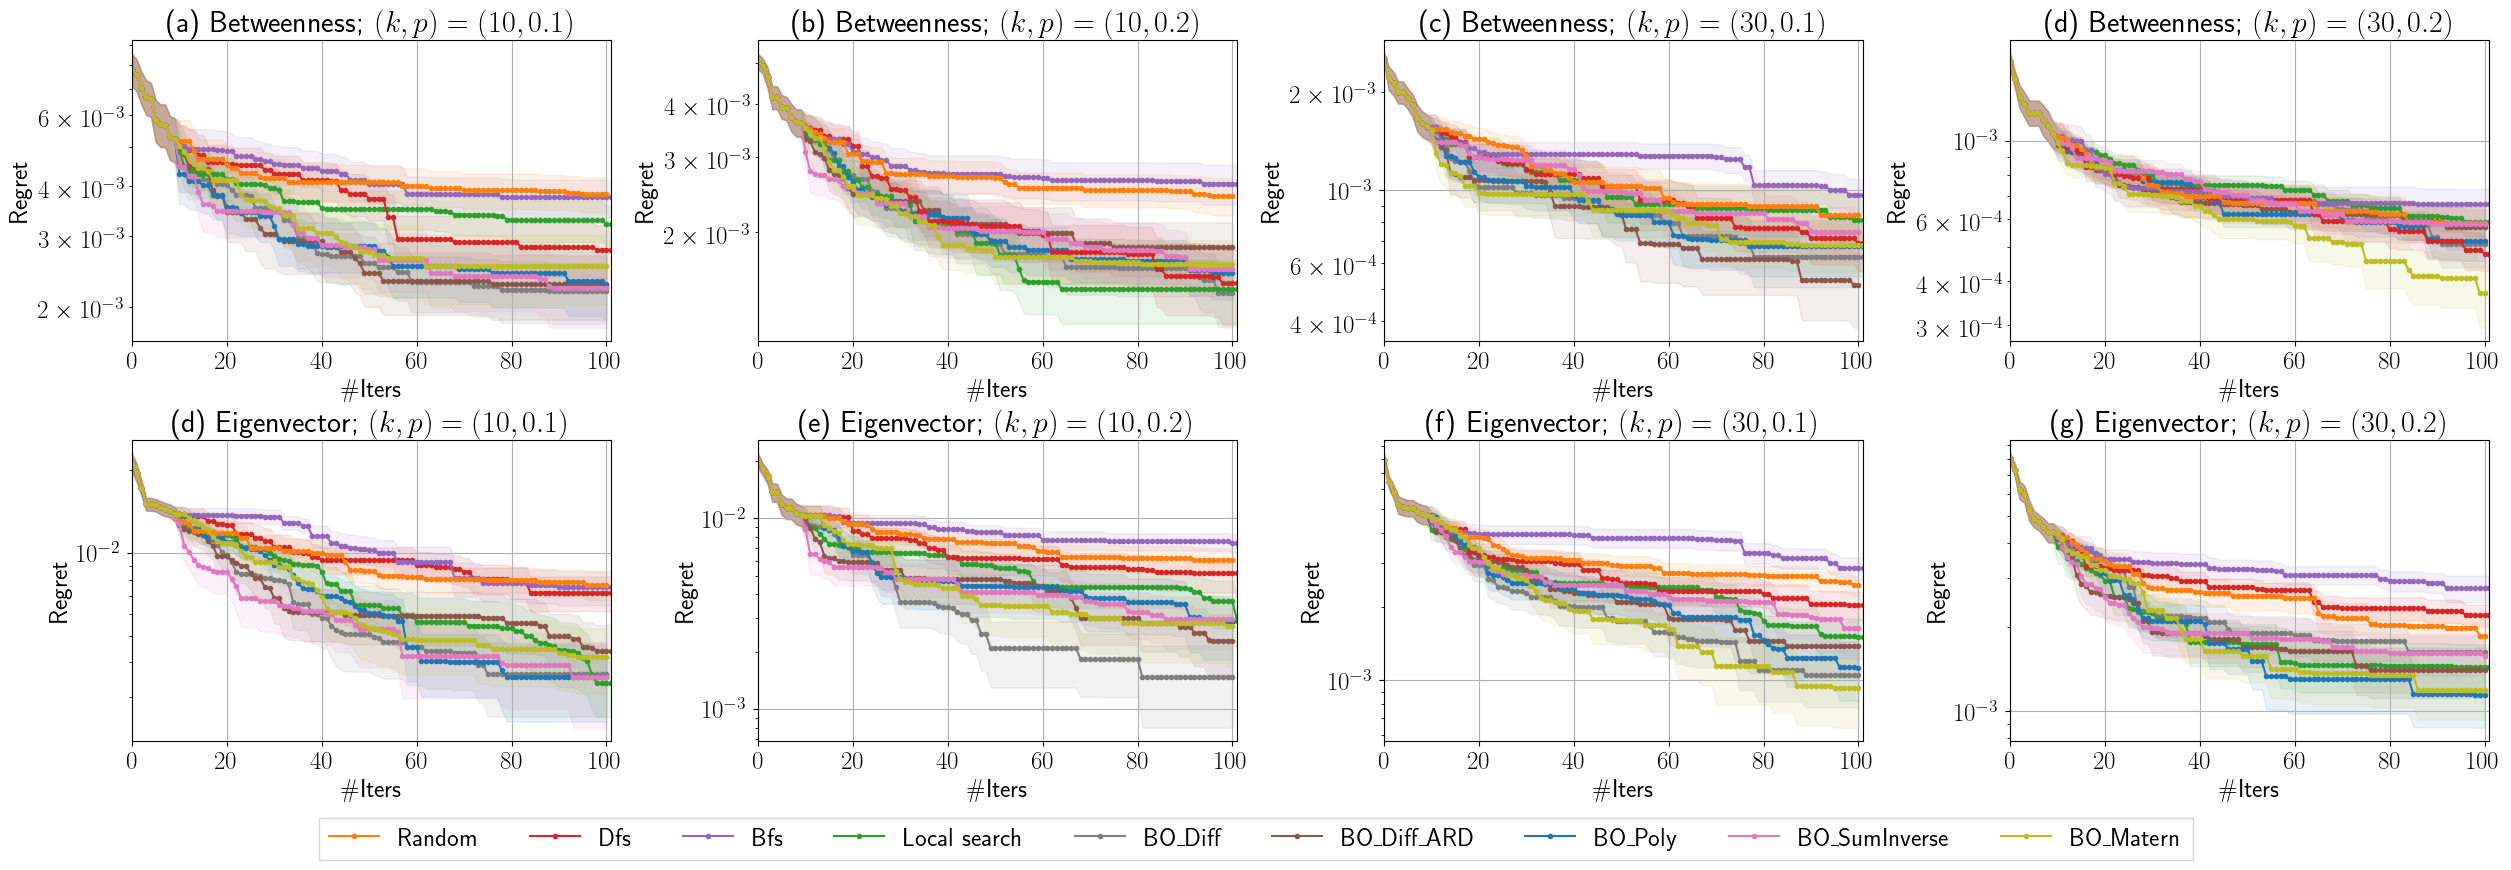

In [7]:
list_experiences = ["ws_betweenness_k-10_p-0.1_ninit-20_n-2000", "ws_betweenness_k-10_p-0.2_ninit-20_n-2000", "ws_betweenness_k-30_p-0.1_ninit-20_n-2000", "ws_betweenness_k-30_p-0.2_ninit-20_n-2000",
                    "ws_eigenvector_centrality_k-10_p-0.1_ninit-20_n-2000", "ws_eigenvector_centrality_k-10_p-0.2_ninit-20_n-2000", "ws_eigenvector_centrality_k-30_p-0.1_ninit-20_n-2000", "ws_eigenvector_centrality_k-30_p-0.2_ninit-20_n-2000"]
n_rows, n_cols = 2, 4
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(25, 8))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_row, idx_col], "./logs/centrality/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [6, 4, 5, 1, 0, 2, 3, 7, 8]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('(a) Betweenness; ' + r'$(k, p)=(10, 0.1)$')
axs[0, 0].set_yscale("log")
axs[0, 1].title.set_text('(b) Betweenness; ' + r'$(k, p)=(10, 0.2)$')
axs[0, 1].set_yscale("log")
axs[0, 2].title.set_text('(c) Betweenness; ' + r'$(k, p)=(30, 0.1)$')
axs[0, 2].set_yscale("log")
axs[0, 3].title.set_text('(d) Betweenness; ' + r'$(k, p)=(30, 0.2)$')
axs[0, 3].set_yscale("log")
axs[1, 0].title.set_text('(d) Eigenvector; ' + r'$(k, p)=(10, 0.1)$')
axs[1, 0].set_yscale("log")
axs[1, 1].title.set_text('(e) Eigenvector; ' + r'$(k, p)=(10, 0.2)$')
axs[1, 1].set_yscale("log")
axs[1, 2].title.set_text('(f) Eigenvector; ' + r'$(k, p)=(30, 0.1)$')
axs[1, 2].set_yscale("log")
axs[1, 3].title.set_text('(g) Eigenvector; ' + r'$(k, p)=(30, 0.2)$')
axs[1, 3].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9)
#plt.legend()
#plt.show()
plt.savefig("centrality_ws.pdf", bbox_inches='tight')

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3


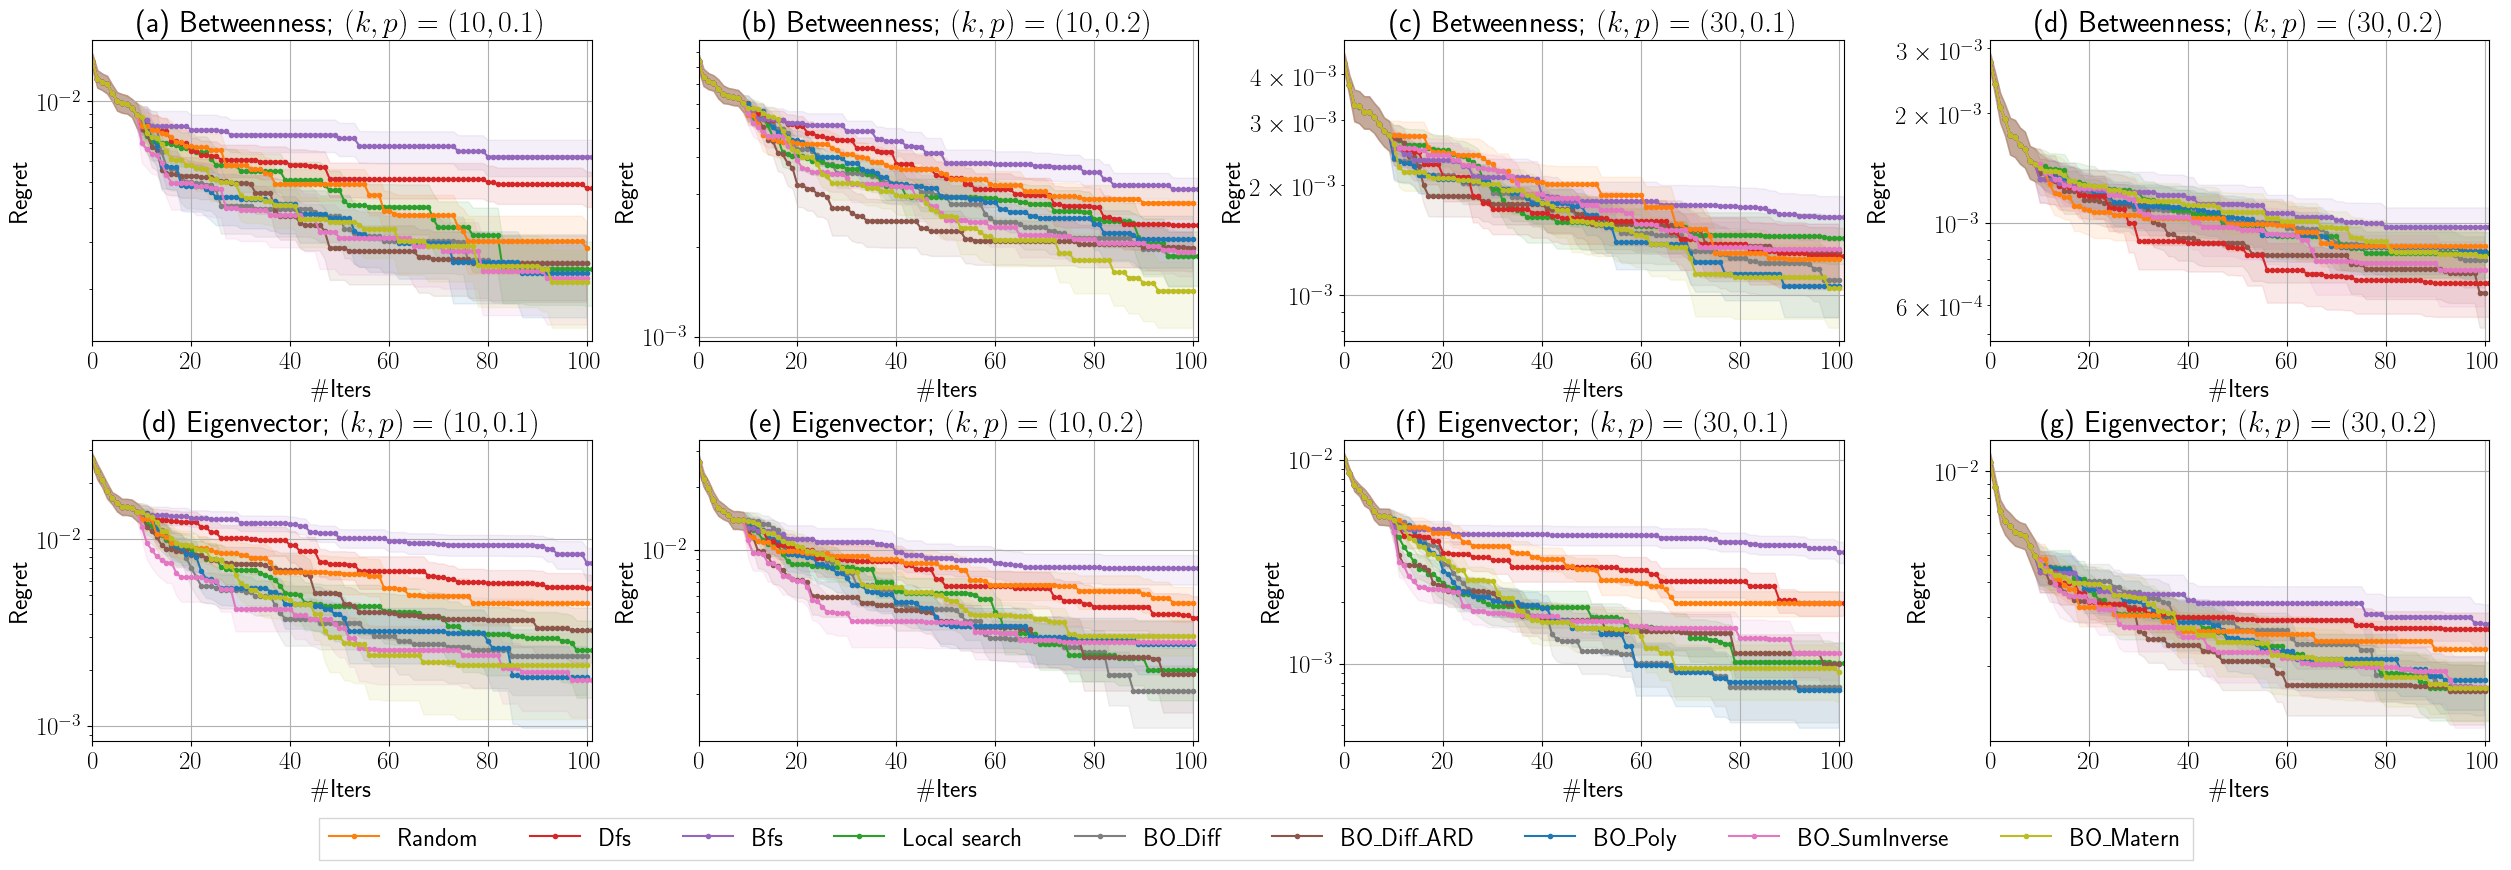

In [6]:
list_experiences = ["ws_betweenness_k-10_p-0.1_ninit-20_n-1000", "ws_betweenness_k-10_p-0.2_ninit-20_n-1000", "ws_betweenness_k-30_p-0.1_ninit-20_n-1000", "ws_betweenness_k-30_p-0.2_ninit-20_n-1000",
                    "ws_eigenvector_centrality_k-10_p-0.1_ninit-20_n-1000", "ws_eigenvector_centrality_k-10_p-0.2_ninit-20_n-1000", "ws_eigenvector_centrality_k-30_p-0.1_ninit-20_n-1000", "ws_eigenvector_centrality_k-30_p-0.2_ninit-20_n-1000"]
n_rows, n_cols = 2, 4
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(25, 8))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_row, idx_col], "./logs/centrality/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [6, 4, 5, 1, 0, 2, 3, 7, 8]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('(a) Betweenness; ' + r'$(k, p)=(10, 0.1)$')
axs[0, 0].set_yscale("log")
axs[0, 1].title.set_text('(b) Betweenness; ' + r'$(k, p)=(10, 0.2)$')
axs[0, 1].set_yscale("log")
axs[0, 2].title.set_text('(c) Betweenness; ' + r'$(k, p)=(30, 0.1)$')
axs[0, 2].set_yscale("log")
axs[0, 3].title.set_text('(d) Betweenness; ' + r'$(k, p)=(30, 0.2)$')
axs[0, 3].set_yscale("log")
axs[1, 0].title.set_text('(d) Eigenvector; ' + r'$(k, p)=(10, 0.1)$')
axs[1, 0].set_yscale("log")
axs[1, 1].title.set_text('(e) Eigenvector; ' + r'$(k, p)=(10, 0.2)$')
axs[1, 1].set_yscale("log")
axs[1, 2].title.set_text('(f) Eigenvector; ' + r'$(k, p)=(30, 0.1)$')
axs[1, 2].set_yscale("log")
axs[1, 3].title.set_text('(g) Eigenvector; ' + r'$(k, p)=(30, 0.2)$')
axs[1, 3].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9)
#plt.legend()
#plt.show()
plt.savefig("centrality_ws.pdf", bbox_inches='tight')

# Team Optimization centrality

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


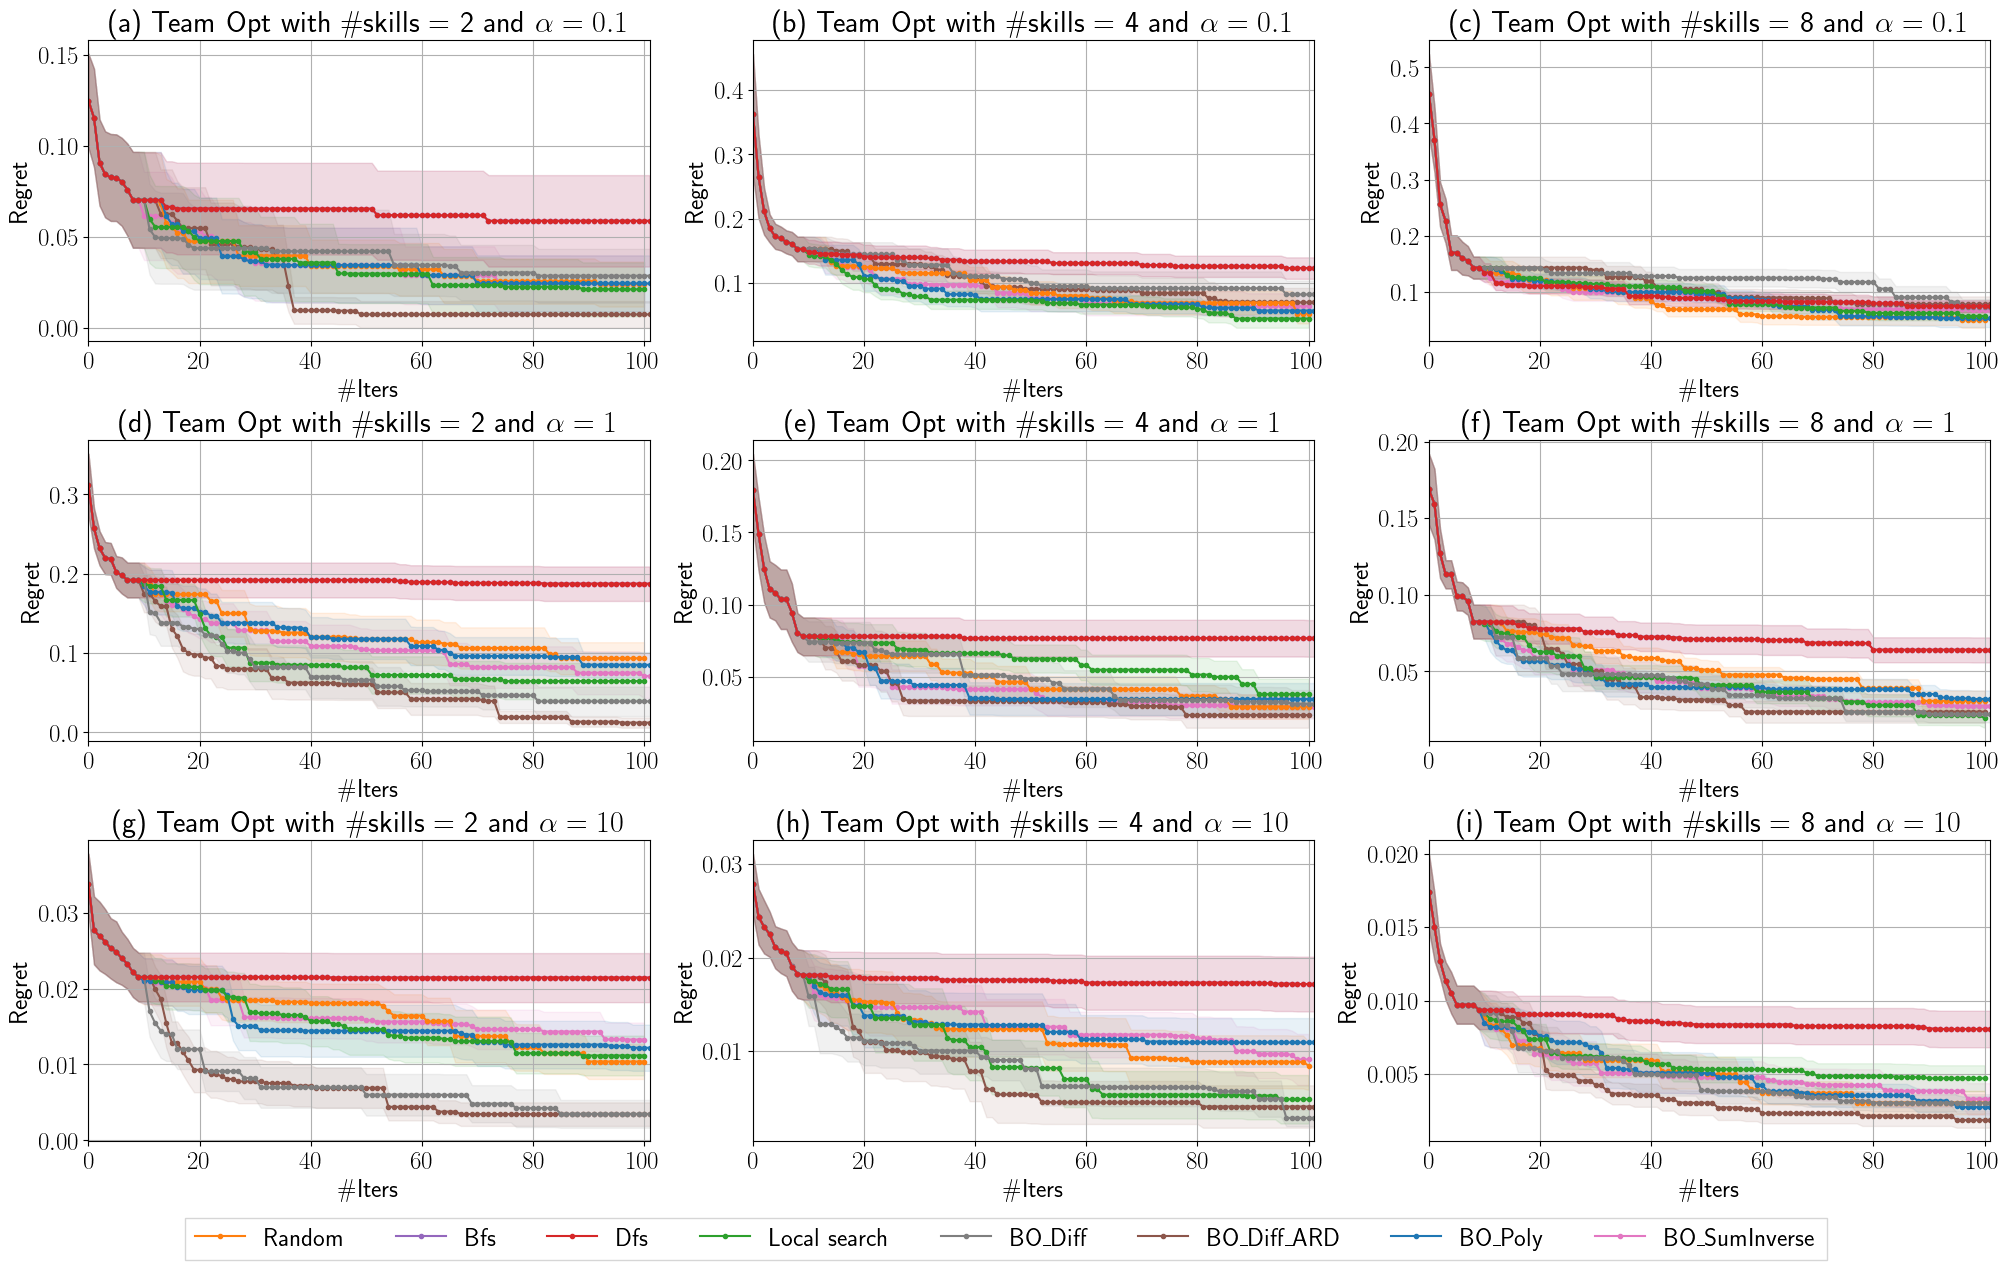

In [25]:
plt.rcParams['text.usetex'] = True
list_experiences = ["jaccard_n_skills-2_alpha-0.1_n_individuals-10_threshold-0.1", "jaccard_n_skills-2_alpha-1_n_individuals-10_threshold-0.1", "jaccard_n_skills-2_alpha-10_n_individuals-10_threshold-0.1",
                    "jaccard_n_skills-4_alpha-0.1_n_individuals-10_threshold-0.1", "jaccard_n_skills-4_alpha-1_n_individuals-10_threshold-0.1", "jaccard_n_skills-4_alpha-10_n_individuals-10_threshold-0.1",
                    "jaccard_n_skills-8_alpha-0.1_n_individuals-10_threshold-0.1", "jaccard_n_skills-8_alpha-1_n_individuals-10_threshold-0.1", "jaccard_n_skills-8_alpha-10_n_individuals-10_threshold-0.1"]
n_rows, n_cols = 3, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 12))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_col, idx_row], "./logs/teams/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('(a) Team Opt with ' + r'\#skills = 2' + ' and ' + r'$\alpha = 0.1$')
axs[0, 1].title.set_text('(b) Team Opt with ' + r'\#skills = 4' + ' and ' + r'$\alpha = 0.1$')
axs[0, 2].title.set_text('(c) Team Opt with ' + r'\#skills = 8' + ' and ' + r'$\alpha = 0.1$')
axs[1, 0].title.set_text('(d) Team Opt with ' + r'\#skills = 2' + ' and ' + r'$\alpha = 1$')
axs[1, 1].title.set_text('(e) Team Opt with ' + r'\#skills = 4' + ' and ' + r'$\alpha = 1$')
axs[1, 2].title.set_text('(f) Team Opt with ' + r'\#skills = 8' + ' and ' + r'$\alpha = 1$')
axs[2, 0].title.set_text('(g) Team Opt with ' + r'\#skills = 2' + ' and ' + r'$\alpha = 10$')
axs[2, 1].title.set_text('(h) Team Opt with ' + r'\#skills = 4' + ' and ' + r'$\alpha = 10$')
axs[2, 2].title.set_text('(i) Team Opt with ' + r'\#skills = 8' + ' and ' + r'$\alpha = 10$')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
#plt.show()
plt.savefig("teamopt_01.pdf", bbox_inches='tight')

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


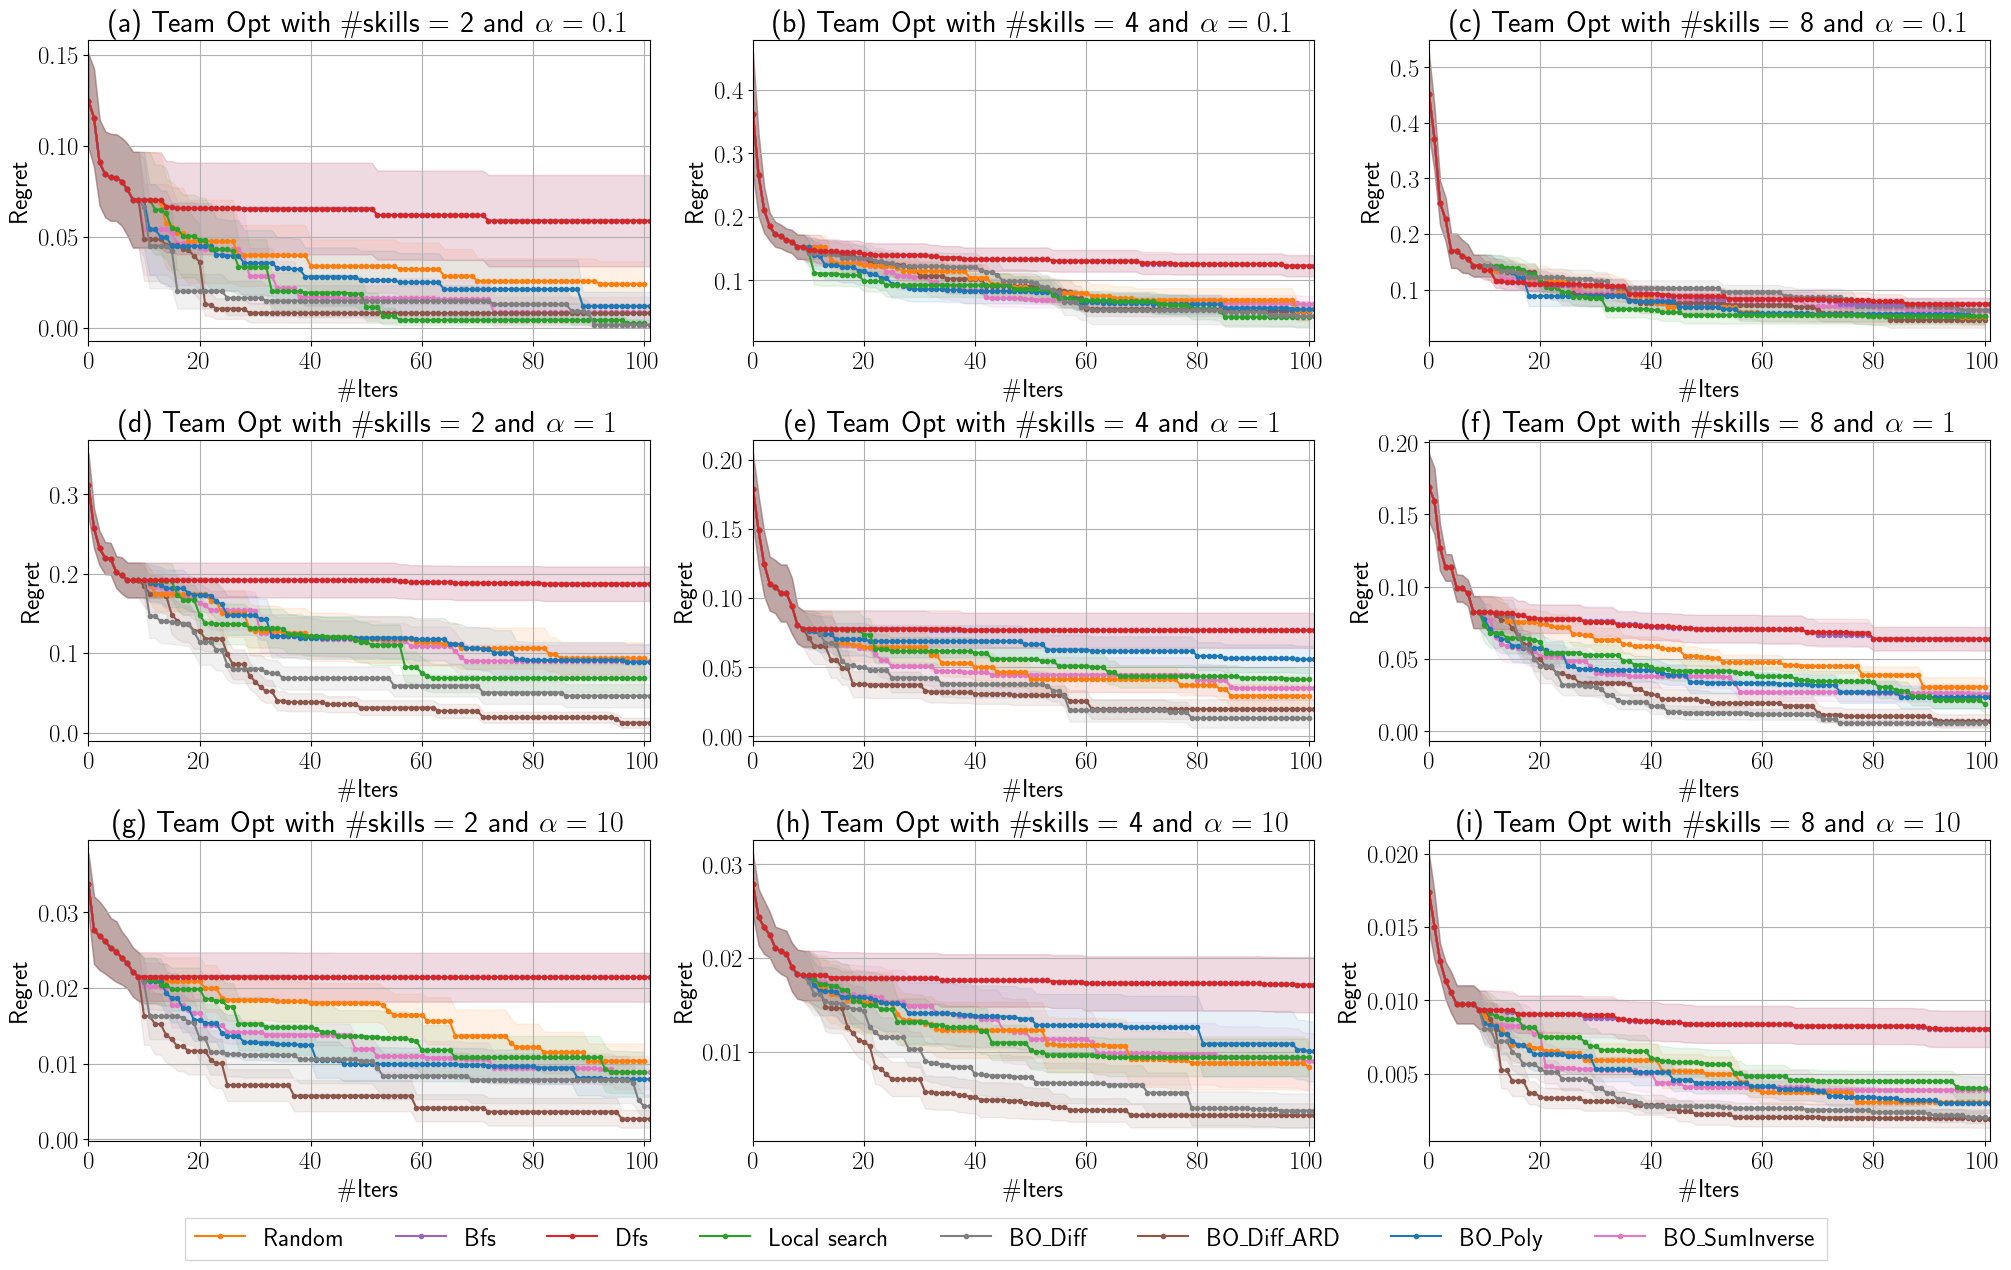

In [26]:
plt.rcParams['text.usetex'] = True
list_experiences = ["jaccard_n_skills-2_alpha-0.1_n_individuals-10_threshold-0.2", "jaccard_n_skills-2_alpha-1_n_individuals-10_threshold-0.2", "jaccard_n_skills-2_alpha-10_n_individuals-10_threshold-0.2",
                    "jaccard_n_skills-4_alpha-0.1_n_individuals-10_threshold-0.2", "jaccard_n_skills-4_alpha-1_n_individuals-10_threshold-0.2", "jaccard_n_skills-4_alpha-10_n_individuals-10_threshold-0.2",
                    "jaccard_n_skills-8_alpha-0.1_n_individuals-10_threshold-0.2", "jaccard_n_skills-8_alpha-1_n_individuals-10_threshold-0.2", "jaccard_n_skills-8_alpha-10_n_individuals-10_threshold-0.2"]
n_rows, n_cols = 3, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 12))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_col, idx_row], "./logs/teams/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('(a) Team Opt with ' + r'\#skills = 2' + ' and ' + r'$\alpha = 0.1$')
axs[0, 1].title.set_text('(b) Team Opt with ' + r'\#skills = 4' + ' and ' + r'$\alpha = 0.1$')
axs[0, 2].title.set_text('(c) Team Opt with ' + r'\#skills = 8' + ' and ' + r'$\alpha = 0.1$')
axs[1, 0].title.set_text('(d) Team Opt with ' + r'\#skills = 2' + ' and ' + r'$\alpha = 1$')
axs[1, 1].title.set_text('(e) Team Opt with ' + r'\#skills = 4' + ' and ' + r'$\alpha = 1$')
axs[1, 2].title.set_text('(f) Team Opt with ' + r'\#skills = 8' + ' and ' + r'$\alpha = 1$')
axs[2, 0].title.set_text('(g) Team Opt with ' + r'\#skills = 2' + ' and ' + r'$\alpha = 10$')
axs[2, 1].title.set_text('(h) Team Opt with ' + r'\#skills = 4' + ' and ' + r'$\alpha = 10$')
axs[2, 2].title.set_text('(i) Team Opt with ' + r'\#skills = 8' + ' and ' + r'$\alpha = 10$')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
#plt.show()
plt.savefig("teamopt_02.pdf", bbox_inches='tight')

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


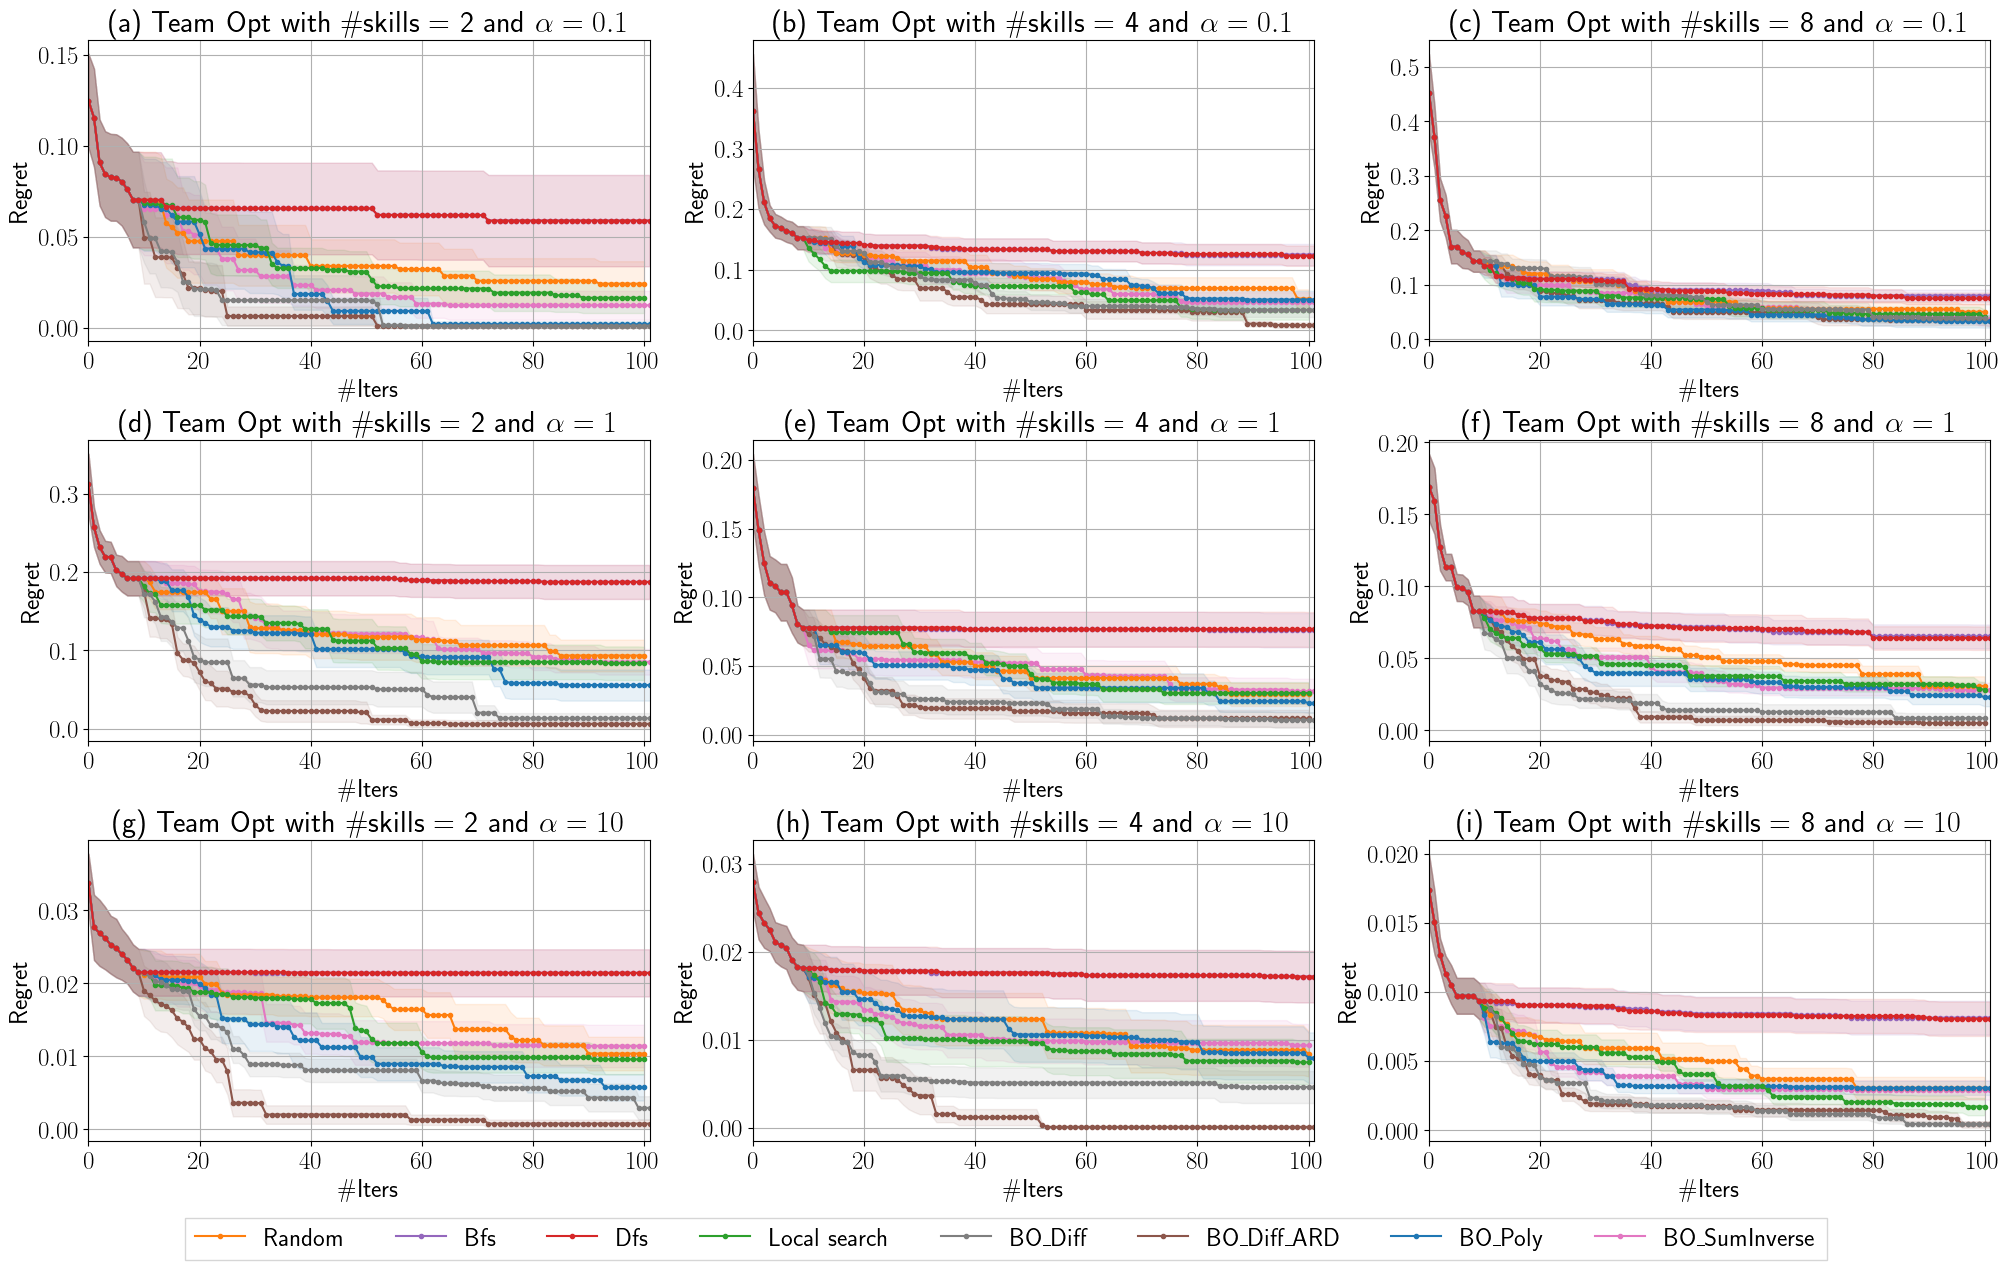

In [27]:
plt.rcParams['text.usetex'] = True
list_experiences = ["jaccard_n_skills-2_alpha-0.1_n_individuals-10_threshold-0.3", "jaccard_n_skills-2_alpha-1_n_individuals-10_threshold-0.3", "jaccard_n_skills-2_alpha-10_n_individuals-10_threshold-0.3",
                    "jaccard_n_skills-4_alpha-0.1_n_individuals-10_threshold-0.3", "jaccard_n_skills-4_alpha-1_n_individuals-10_threshold-0.3", "jaccard_n_skills-4_alpha-10_n_individuals-10_threshold-0.3",
                    "jaccard_n_skills-8_alpha-0.1_n_individuals-10_threshold-0.3", "jaccard_n_skills-8_alpha-1_n_individuals-10_threshold-0.3", "jaccard_n_skills-8_alpha-10_n_individuals-10_threshold-0.3"]
n_rows, n_cols = 3, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 12))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_col, idx_row], "./logs/teams/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('(a) Team Opt with ' + r'\#skills = 2' + ' and ' + r'$\alpha = 0.1$')
axs[0, 1].title.set_text('(b) Team Opt with ' + r'\#skills = 4' + ' and ' + r'$\alpha = 0.1$')
axs[0, 2].title.set_text('(c) Team Opt with ' + r'\#skills = 8' + ' and ' + r'$\alpha = 0.1$')
axs[1, 0].title.set_text('(d) Team Opt with ' + r'\#skills = 2' + ' and ' + r'$\alpha = 1$')
axs[1, 1].title.set_text('(e) Team Opt with ' + r'\#skills = 4' + ' and ' + r'$\alpha = 1$')
axs[1, 2].title.set_text('(f) Team Opt with ' + r'\#skills = 8' + ' and ' + r'$\alpha = 1$')
axs[2, 0].title.set_text('(g) Team Opt with ' + r'\#skills = 2' + ' and ' + r'$\alpha = 10$')
axs[2, 1].title.set_text('(h) Team Opt with ' + r'\#skills = 4' + ' and ' + r'$\alpha = 10$')
axs[2, 2].title.set_text('(i) Team Opt with ' + r'\#skills = 8' + ' and ' + r'$\alpha = 10$')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
#plt.show()
plt.savefig("teamopt_03.pdf", bbox_inches='tight')

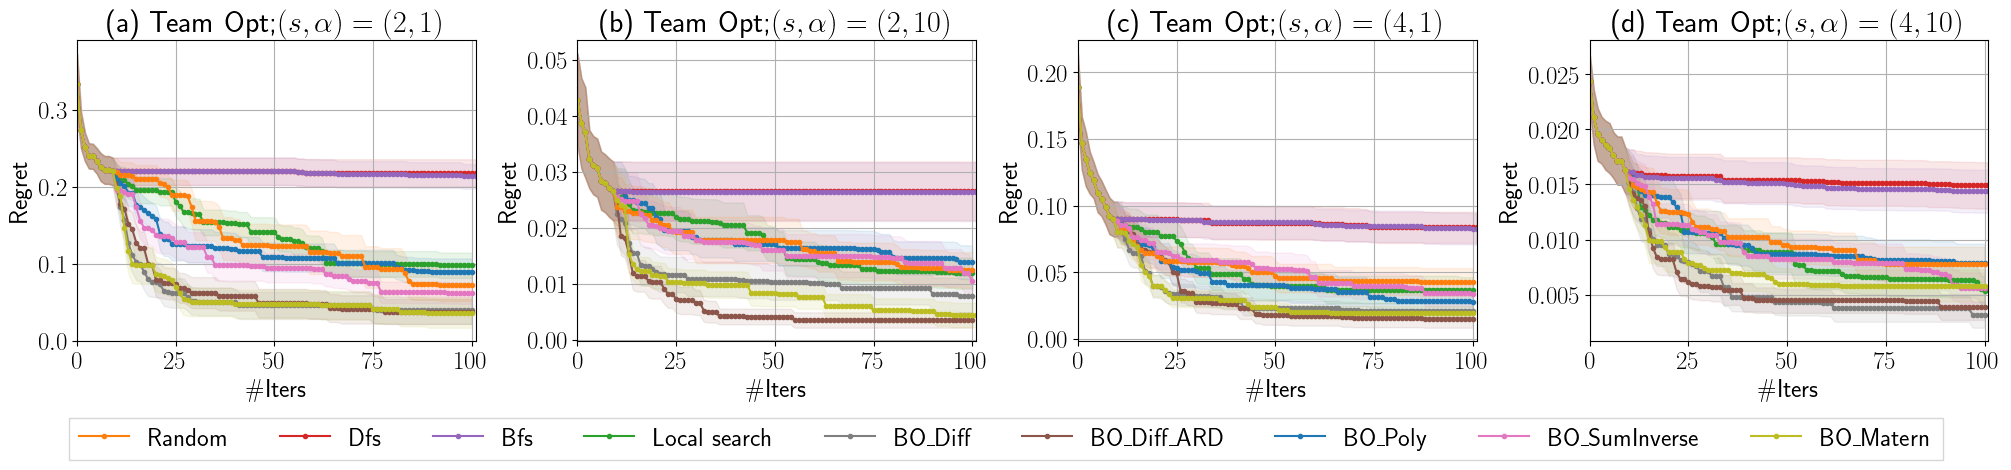

In [8]:
plt.rcParams['text.usetex'] = True
list_experiences = ["jaccard_n_skills-2_alpha-1_n_individuals-10_threshold-0.3", "jaccard_n_skills-2_alpha-10_n_individuals-10_threshold-0.3", "jaccard_n_skills-4_alpha-1_n_individuals-10_threshold-0.3", "jaccard_n_skills-4_alpha-10_n_individuals-10_threshold-0.3"]
n_rows, n_cols = 1, 4
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 4))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    #print(idx_row, idx_col)
    plot_result(axs[idx_col], "./logs/team/", list_experiences[i], std=False)

handles, labels = axs[idx_col].get_legend_handles_labels()
change_labels = [6, 4, 5, 1, 0, 2, 3, 7, 8]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')

axs[0].title.set_text('(a) Team Opt;' + r'$(s, \alpha)=(2, 1)$')
axs[1].title.set_text('(b) Team Opt;' + r'$(s, \alpha)=(2, 10)$')
axs[2].title.set_text('(c) Team Opt;' + r'$(s, \alpha)=(4, 1)$')
axs[3].title.set_text('(d) Team Opt;' + r'$(s, \alpha)=(4, 10)$')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9)
#plt.legend()
#plt.show()
plt.savefig("teamopt_small_03.pdf", bbox_inches='tight')

# Test Function

In [7]:
plt.rcParams['text.usetex'] = True
list_experiences = ["ackley_noise-0.0_n-1000", "ackley_noise-0.2_n-1000", "ackley_noise-0.5_n-1000", "ackley_noise-1.0_n-1000",
                    "rosenbrock_noise-0.0_n-1000", "rosenbrock_noise-0.2_n-1000", "rosenbrock_noise-0.5_n-1000", "rosenbrock_noise-1.0_n-1000", 
                    "sphere_noise-0.0_n-1000", "sphere_noise-0.2_n-1000", "sphere_noise-0.5_n-1000", "sphere_noise-1.0_n-1000"]
n_rows, n_cols = 3, 4
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 12))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_row, idx_col], "./logs/testfunction/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('(a) Ackley function; ' + r'$\sigma = 0.0$')
axs[0, 1].title.set_text('(b) Ackley function; ' + r'$\sigma = 0.2$')
axs[0, 2].title.set_text('(c) Ackley function; ' + r'$\sigma = 0.5$')
axs[0, 3].title.set_text('(d) Ackley function; ' + r'$\sigma = 1.0$')

axs[1, 0].title.set_text('(e) Rosenbrock function; ' + r'$\sigma = 0.0$')
axs[1, 0].set_yscale("log")
axs[1, 1].title.set_text('(f) Rosenbrock function; ' + r'$\sigma = 0.2$')
axs[1, 1].set_yscale("log")
axs[1, 2].title.set_text('(g) Rosenbrock function; ' + r'$\sigma = 0.5$')
axs[1, 2].set_yscale("log")
axs[1, 3].title.set_text('(h) Rosenbrock function; ' + r'$\sigma = 1.0$')
axs[1, 3].set_yscale("log")

axs[2, 0].title.set_text('(i) Sphere function; ' + r'$\sigma = 0.0$')
axs[2, 0].set_yscale("log")
axs[2, 1].title.set_text('(j) Sphere function; ' + r'$\sigma = 0.2$')
axs[2, 1].set_yscale("log")
axs[2, 2].title.set_text('(k) Sphere function; ' + r'$\sigma = 0.5$')
axs[2, 2].set_yscale("log")
axs[2, 3].title.set_text('(l) Sphere function; ' + r'$\sigma = 1.0$')
axs[2, 3].set_yscale("log")

fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
#plt.show()
plt.savefig("test_function_supp.pdf", bbox_inches='tight')

0 0
0 1


FileNotFoundError: [Errno 2] No such file or directory: './logs/testfunction/ackley_noise-0.2_n-1000'

Error in callback <function _draw_all_if_interactive at 0x7fba223c4b80> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 2000x1200 with 12 Axes>

In [8]:
plt.rcParams['text.usetex'] = True
list_experiences = ["ackley_noise-0.5_n-1000", "rosenbrock_noise-0.5_n-1000", "sphere_noise-0.5_n-1000",
                    "ackley_noise-1.0_n-1000", "rosenbrock_noise-1.0_n-1000", "sphere_noise-1.0_n-1000"]
n_rows, n_cols = 2, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_row, idx_col], "./logs/testfunction/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('(a) Ackley function with ' + r'$\sigma = 0.5$')
axs[0, 1].title.set_text('(b) Rosenbrock function with ' + r'$\sigma = 0.5$')
axs[0, 1].set_yscale("log")
axs[0, 2].title.set_text('(c) Sphere function with ' + r'$\sigma = 0.5$')
axs[1, 2].set_yscale("log")
axs[1, 0].title.set_text('(d) Ackley function with ' + r'$\sigma = 1$')
axs[1, 1].title.set_text('(e) Rosenbrock function with ' + r'$\sigma = 1$')
axs[1, 1].set_yscale("log")
axs[1, 2].title.set_text('(f) Sphere function with ' + r'$\sigma = 1$')
axs[1, 2].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
#plt.show()
plt.savefig("test_function.pdf", bbox_inches='tight')

0 0
0 1
0 2


FileNotFoundError: [Errno 2] No such file or directory: './logs/testfunction/sphere_noise-0.5_n-1000'

Error in callback <function _draw_all_if_interactive at 0x7fba223c4b80> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 2000x800 with 6 Axes>

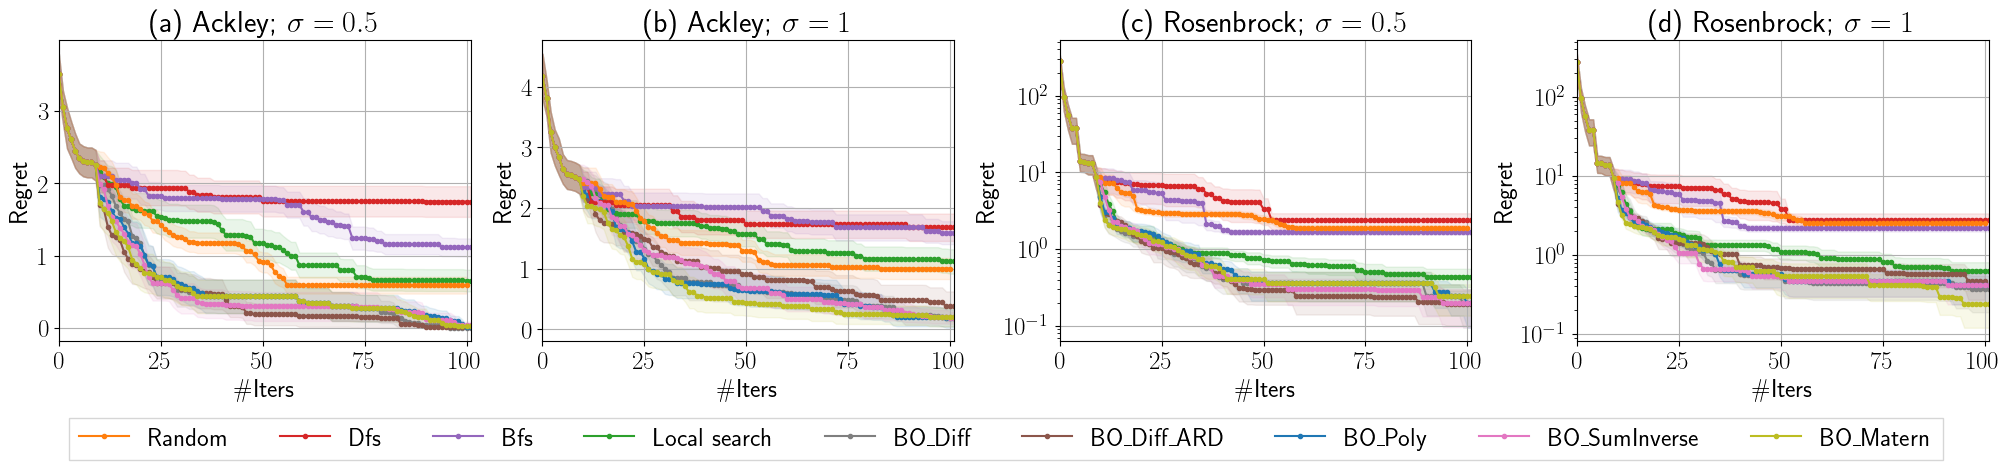

In [13]:
plt.rcParams['text.usetex'] = True
list_experiences = ["ackley_noise-0.5_n-1000", "ackley_noise-1.0_n-1000",
                    "rosenbrock_noise-0.5_n-1000", "rosenbrock_noise-1.0_n-1000"]
n_rows, n_cols = 1, 4
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 4))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    plot_result(axs[idx_col], "./logs/testfunction/", list_experiences[i], std=False)

handles, labels = axs[idx_col].get_legend_handles_labels()
change_labels = [6, 4, 5, 1, 0, 2, 3, 7, 8]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0].title.set_text('(a) Ackley; ' + r'$\sigma = 0.5$')
axs[1].title.set_text('(b) Ackley; ' + r'$\sigma = 1$')
axs[2].title.set_text('(c) Rosenbrock; ' + r'$\sigma = 0.5$')
axs[2].set_yscale("log")
axs[3].title.set_text('(d) Rosenbrock; ' + r'$\sigma = 1$')
axs[3].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9)
#plt.legend()
#plt.show()
plt.savefig("test_function_row.pdf", bbox_inches='tight')

# Real Diffusion

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


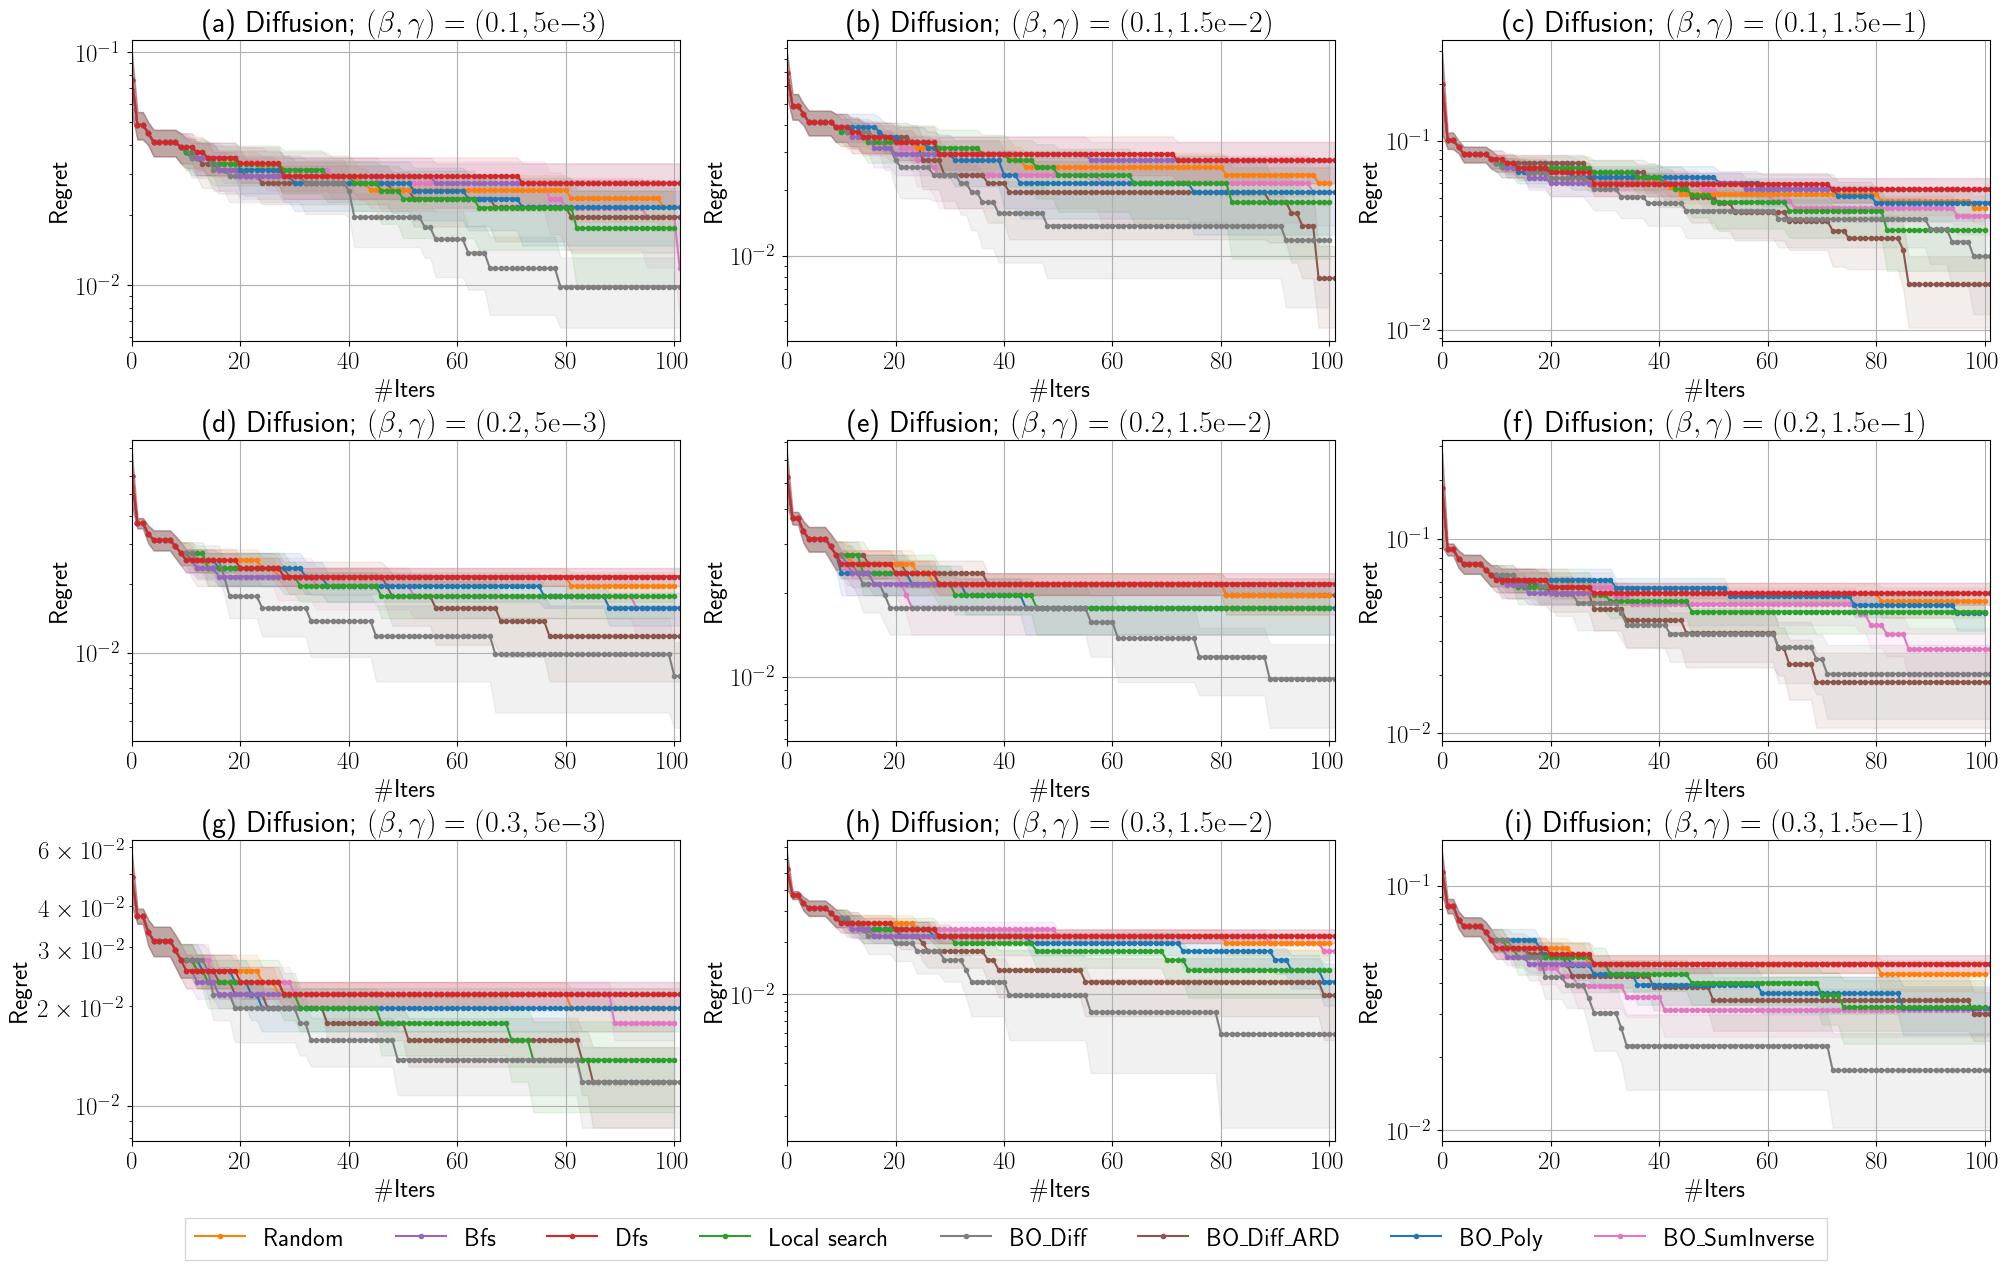

In [23]:
plt.rcParams['text.usetex'] = True
list_experiences = ["beta-0.1_gamma-0.005_fracinfect-3e-4", "beta-0.1_gamma-0.015_fracinfect-3e-4", "beta-0.1_gamma-0.15_fracinfect-3e-4",
                    "beta-0.2_gamma-0.005_fracinfect-3e-4", "beta-0.2_gamma-0.015_fracinfect-3e-4", "beta-0.2_gamma-0.15_fracinfect-3e-4",
                    "beta-0.3_gamma-0.005_fracinfect-3e-4", "beta-0.3_gamma-0.015_fracinfect-3e-4", "beta-0.3_gamma-0.15_fracinfect-3e-4"]
n_rows, n_cols = 3, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 12))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_row, idx_col], "./logs/diffusion_real/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('(a) Diffusion; ' + r'$(\beta, \gamma) = (0.1, 5\mathrm{e}{-3})$')
axs[0, 0].set_yscale("log")
axs[0, 1].title.set_text('(b) Diffusion; ' + r'$(\beta, \gamma) = (0.1, 1.5\mathrm{e}{-2})$')
axs[0, 1].set_yscale("log")
axs[0, 2].title.set_text('(c) Diffusion; ' + r'$(\beta, \gamma) = (0.1, 1.5\mathrm{e}{-1})$')
axs[0, 2].set_yscale("log")
axs[1, 0].title.set_text('(d) Diffusion; ' + r'$(\beta, \gamma) = (0.2, 5\mathrm{e}{-3})$')
axs[1, 0].set_yscale("log")
axs[1, 1].title.set_text('(e) Diffusion; ' + r'$(\beta, \gamma) = (0.2, 1.5\mathrm{e}{-2})$')
axs[1, 1].set_yscale("log")
axs[1, 2].title.set_text('(f) Diffusion; ' + r'$(\beta, \gamma) = (0.2, 1.5\mathrm{e}{-1})$')
axs[1, 2].set_yscale("log")
axs[2, 0].title.set_text('(g) Diffusion; ' + r'$(\beta, \gamma) = (0.3, 5\mathrm{e}{-3})$')
axs[2, 0].set_yscale("log")
axs[2, 1].title.set_text('(h) Diffusion; ' + r'$(\beta, \gamma) = (0.3, 1.5\mathrm{e}{-2})$')
axs[2, 1].set_yscale("log")
axs[2, 2].title.set_text('(i) Diffusion; ' + r'$(\beta, \gamma) = (0.3, 1.5\mathrm{e}{-1})$')
axs[2, 2].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
#plt.show()
plt.savefig("diffusion_real3e-4.pdf", bbox_inches='tight')

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


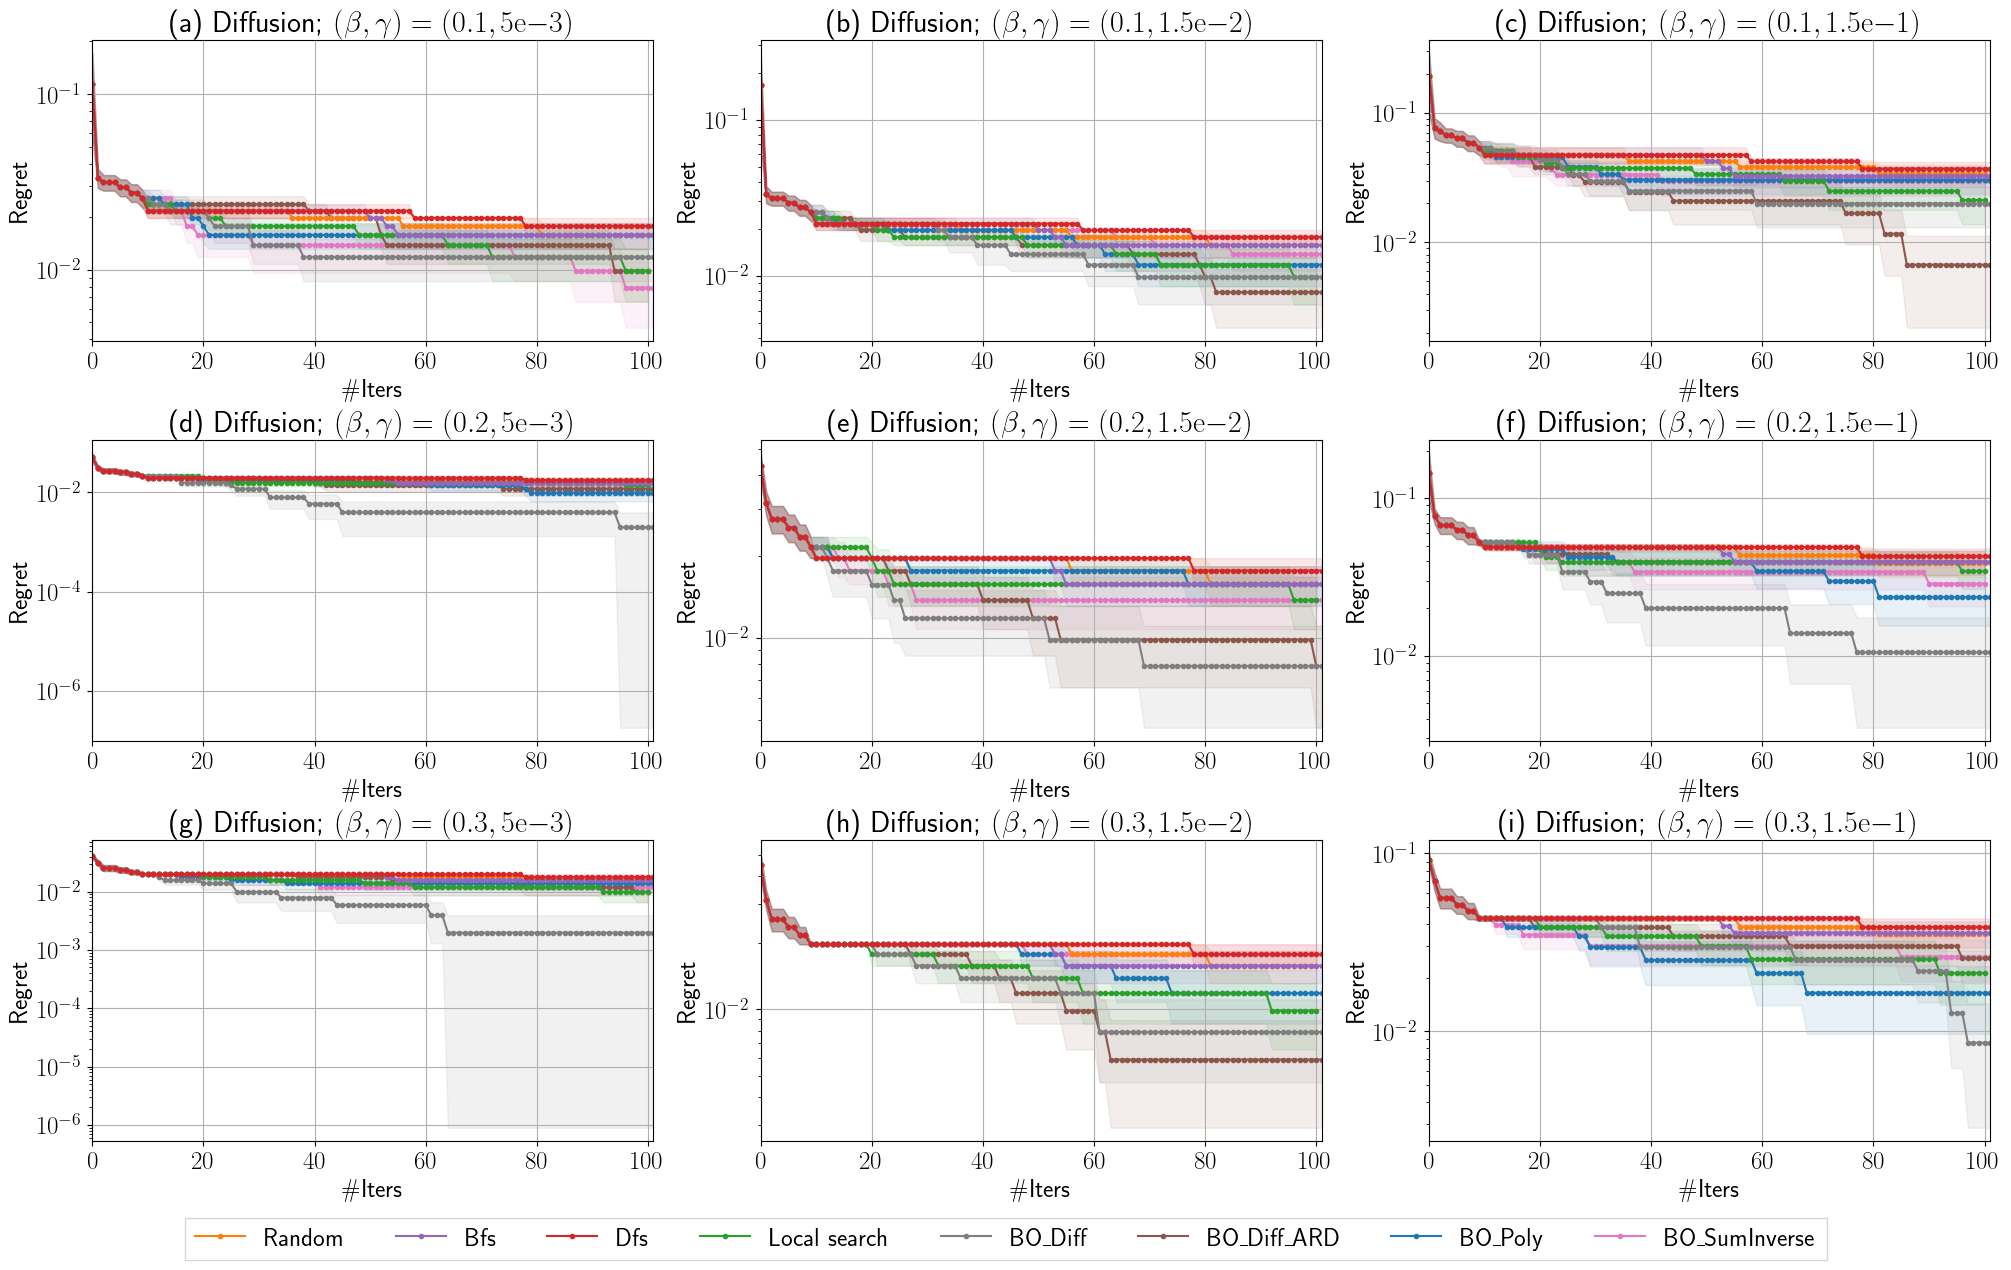

In [22]:
plt.rcParams['text.usetex'] = True
list_experiences = ["beta-0.1_gamma-0.005_fracinfect-3e-3", "beta-0.1_gamma-0.015_fracinfect-3e-3", "beta-0.1_gamma-0.15_fracinfect-3e-3",
                    "beta-0.2_gamma-0.005_fracinfect-3e-3", "beta-0.2_gamma-0.015_fracinfect-3e-3", "beta-0.2_gamma-0.15_fracinfect-3e-3",
                    "beta-0.3_gamma-0.005_fracinfect-3e-3", "beta-0.3_gamma-0.015_fracinfect-3e-3", "beta-0.3_gamma-0.15_fracinfect-3e-3"]
n_rows, n_cols = 3, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 12))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_row, idx_col], "./logs/diffusion_real/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('(a) Diffusion; ' + r'$(\beta, \gamma) = (0.1, 5\mathrm{e}{-3})$')
axs[0, 0].set_yscale("log")
axs[0, 1].title.set_text('(b) Diffusion; ' + r'$(\beta, \gamma) = (0.1, 1.5\mathrm{e}{-2})$')
axs[0, 1].set_yscale("log")
axs[0, 2].title.set_text('(c) Diffusion; ' + r'$(\beta, \gamma) = (0.1, 1.5\mathrm{e}{-1})$')
axs[0, 2].set_yscale("log")
axs[1, 0].title.set_text('(d) Diffusion; ' + r'$(\beta, \gamma) = (0.2, 5\mathrm{e}{-3})$')
axs[1, 0].set_yscale("log")
axs[1, 1].title.set_text('(e) Diffusion; ' + r'$(\beta, \gamma) = (0.2, 1.5\mathrm{e}{-2})$')
axs[1, 1].set_yscale("log")
axs[1, 2].title.set_text('(f) Diffusion; ' + r'$(\beta, \gamma) = (0.2, 1.5\mathrm{e}{-1})$')
axs[1, 2].set_yscale("log")
axs[2, 0].title.set_text('(g) Diffusion; ' + r'$(\beta, \gamma) = (0.3, 5\mathrm{e}{-3})$')
axs[2, 0].set_yscale("log")
axs[2, 1].title.set_text('(h) Diffusion; ' + r'$(\beta, \gamma) = (0.3, 1.5\mathrm{e}{-2})$')
axs[2, 1].set_yscale("log")
axs[2, 2].title.set_text('(i) Diffusion; ' + r'$(\beta, \gamma) = (0.3, 1.5\mathrm{e}{-1})$')
axs[2, 2].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
#plt.show()
plt.savefig("diffusion_real3e-3.pdf", bbox_inches='tight')

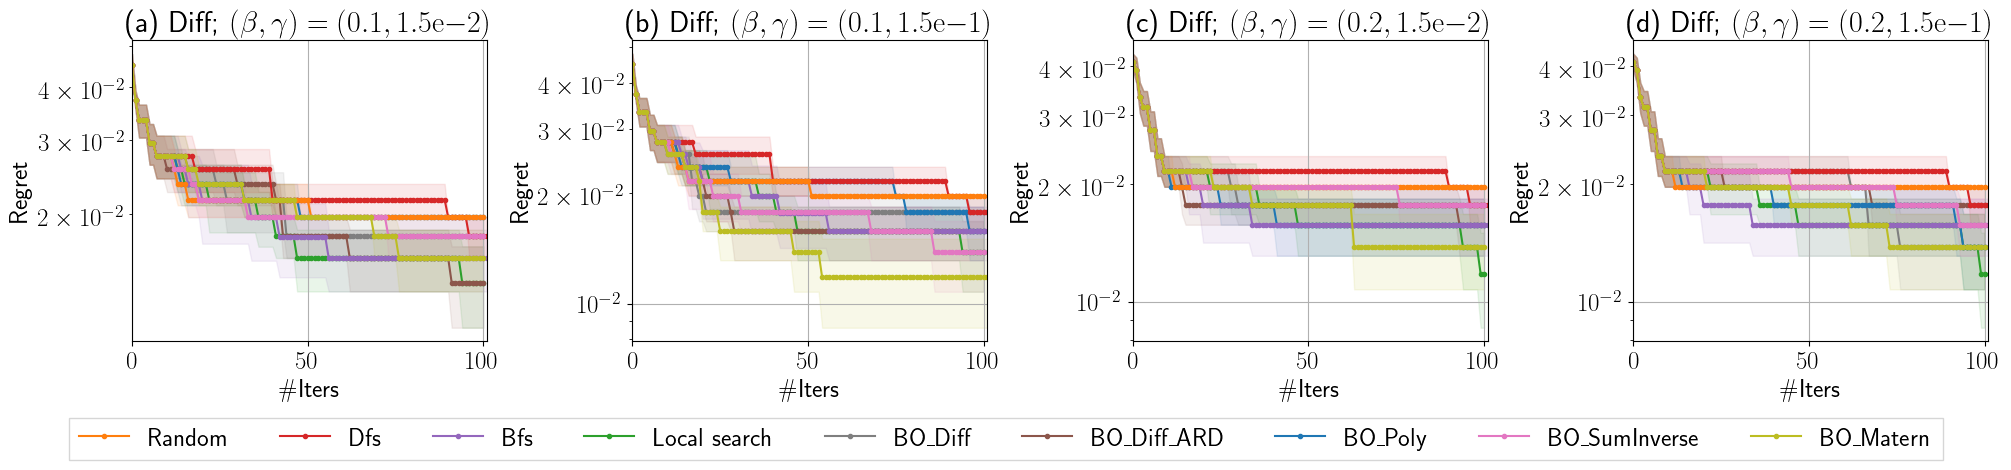

In [11]:
plt.rcParams['text.usetex'] = True
list_experiences = ["beta-0.1_gamma-0.015_epsilon-0.05_fracinfect-3e-4_iter-100", "beta-0.1_gamma-0.15_epsilon-0.05_fracinfect-3e-4_iter-100",
                    "beta-0.2_gamma-0.015_epsilon-0.05_fracinfect-3e-4_iter-100", "beta-0.2_gamma-0.15_epsilon-0.05_fracinfect-3e-4_iter-100"]
n_rows, n_cols = 1, 4
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 4))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    #print(idx_row, idx_col)
    plot_result(axs[idx_col], "./logs/diffusion/", list_experiences[i], std=False)

handles, labels = axs[idx_col].get_legend_handles_labels()
change_labels = [6, 4, 5, 1, 0, 2, 3, 7, 8]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')

axs[0].title.set_text('(a) Diff; ' + r'$(\beta, \gamma) = (0.1, 1.5\mathrm{e}{-2})$')
axs[0].set_yscale("log")
axs[1].title.set_text('(b) Diff; ' + r'$(\beta, \gamma) = (0.1, 1.5\mathrm{e}{-1})$')
axs[1].set_yscale("log")
axs[2].title.set_text('(c) Diff; ' + r'$(\beta, \gamma) = (0.2, 1.5\mathrm{e}{-2})$')
axs[2].set_yscale("log")
axs[3].title.set_text('(d) Diff; ' + r'$(\beta, \gamma) = (0.2, 1.5\mathrm{e}{-1})$')
axs[3].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9)
#plt.legend()
#plt.show()
plt.savefig("diffreal_row.pdf", bbox_inches='tight')

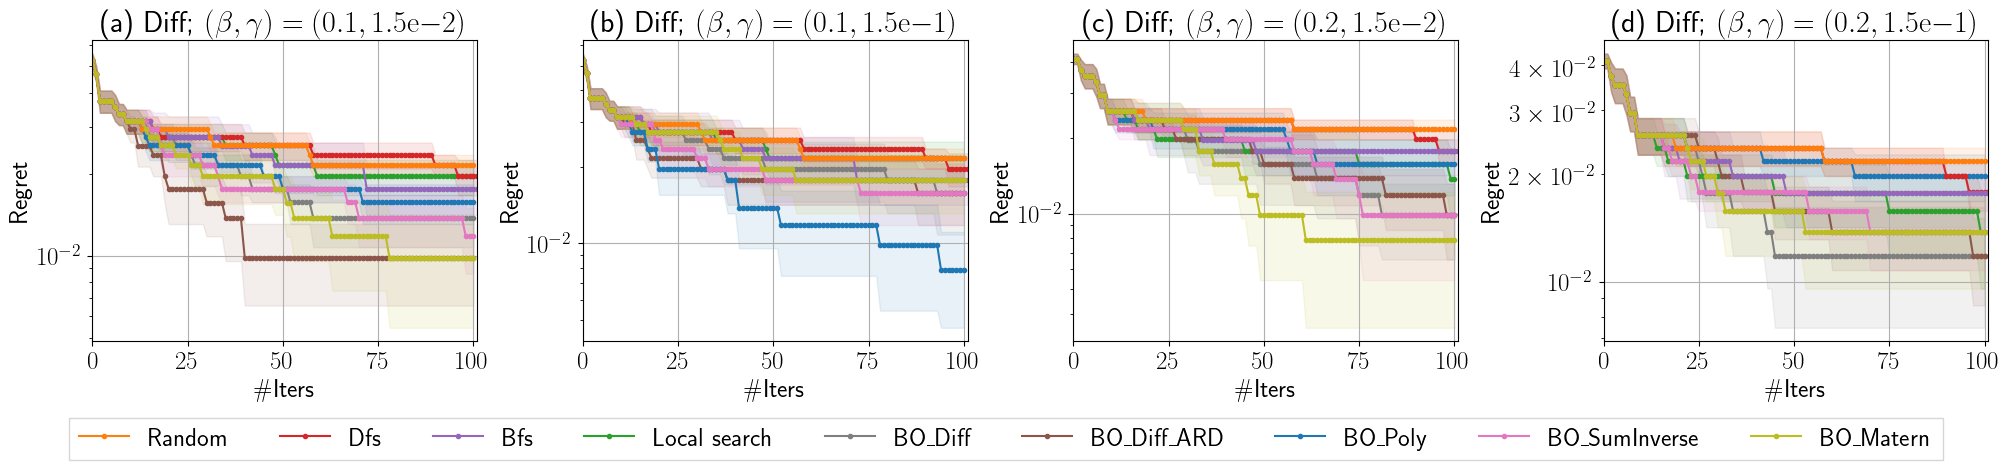

In [12]:
plt.rcParams['text.usetex'] = True
list_experiences = ["beta-0.1_gamma-0.015_epsilon-0.005_fracinfect-3e-4_iter-100", "beta-0.1_gamma-0.15_epsilon-0.005_fracinfect-3e-4_iter-100",
                    "beta-0.2_gamma-0.015_epsilon-0.005_fracinfect-3e-4_iter-100", "beta-0.2_gamma-0.15_epsilon-0.005_fracinfect-3e-4_iter-100"]
n_rows, n_cols = 1, 4
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 4))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    #print(idx_row, idx_col)
    plot_result(axs[idx_col], "./logs/diffusion/", list_experiences[i], std=False)

handles, labels = axs[idx_col].get_legend_handles_labels()
change_labels = [6, 4, 5, 1, 0, 2, 3, 7, 8]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')

axs[0].title.set_text('(a) Diff; ' + r'$(\beta, \gamma) = (0.1, 1.5\mathrm{e}{-2})$')
axs[0].set_yscale("log")
axs[1].title.set_text('(b) Diff; ' + r'$(\beta, \gamma) = (0.1, 1.5\mathrm{e}{-1})$')
axs[1].set_yscale("log")
axs[2].title.set_text('(c) Diff; ' + r'$(\beta, \gamma) = (0.2, 1.5\mathrm{e}{-2})$')
axs[2].set_yscale("log")
axs[3].title.set_text('(d) Diff; ' + r'$(\beta, \gamma) = (0.2, 1.5\mathrm{e}{-1})$')
axs[3].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9)
#plt.legend()
#plt.show()
plt.savefig("diffreal_row.pdf", bbox_inches='tight')

# Synthetic Diffusion

In [ ]:
plt.rcParams['text.usetex'] = True
list_experiences = ["beta-0.1_gamma-0.005_fracinfect-3e-4", "beta-0.1_gamma-0.015_fracinfect-3e-4", "beta-0.1_gamma-0.15_fracinfect-3e-4",
                    "beta-0.2_gamma-0.005_fracinfect-3e-4", "beta-0.2_gamma-0.015_fracinfect-3e-4", "beta-0.2_gamma-0.15_fracinfect-3e-4",
                    "beta-0.3_gamma-0.005_fracinfect-3e-4", "beta-0.3_gamma-0.015_fracinfect-3e-4", "beta-0.3_gamma-0.15_fracinfect-3e-4"]
n_rows, n_cols = 3, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 12))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_row, idx_col], "./logs/diffusion_real/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('(a) Diffusion; ' + r'$(\beta, \gamma) = (0.1, 5\mathrm{e}{-3})$')
axs[0, 0].set_yscale("log")
axs[0, 1].title.set_text('(b) Diffusion; ' + r'$(\beta, \gamma) = (0.1, 1.5\mathrm{e}{-2})$')
axs[0, 1].set_yscale("log")
axs[0, 2].title.set_text('(c) Diffusion; ' + r'$(\beta, \gamma) = (0.1, 1.5\mathrm{e}{-1})$')
axs[0, 2].set_yscale("log")
axs[1, 0].title.set_text('(d) Diffusion; ' + r'$(\beta, \gamma) = (0.2, 5\mathrm{e}{-3})$')
axs[1, 0].set_yscale("log")
axs[1, 1].title.set_text('(e) Diffusion; ' + r'$(\beta, \gamma) = (0.2, 1.5\mathrm{e}{-2})$')
axs[1, 1].set_yscale("log")
axs[1, 2].title.set_text('(f) Diffusion; ' + r'$(\beta, \gamma) = (0.2, 1.5\mathrm{e}{-1})$')
axs[1, 2].set_yscale("log")
axs[2, 0].title.set_text('(g) Diffusion; ' + r'$(\beta, \gamma) = (0.3, 5\mathrm{e}{-3})$')
axs[2, 0].set_yscale("log")
axs[2, 1].title.set_text('(h) Diffusion; ' + r'$(\beta, \gamma) = (0.3, 1.5\mathrm{e}{-2})$')
axs[2, 1].set_yscale("log")
axs[2, 2].title.set_text('(i) Diffusion; ' + r'$(\beta, \gamma) = (0.3, 1.5\mathrm{e}{-1})$')
axs[2, 2].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
#plt.show()
plt.savefig("diffusion_real.pdf", bbox_inches='tight')

# Real Graphs Degree Experiments

0 0
1 0
2 0


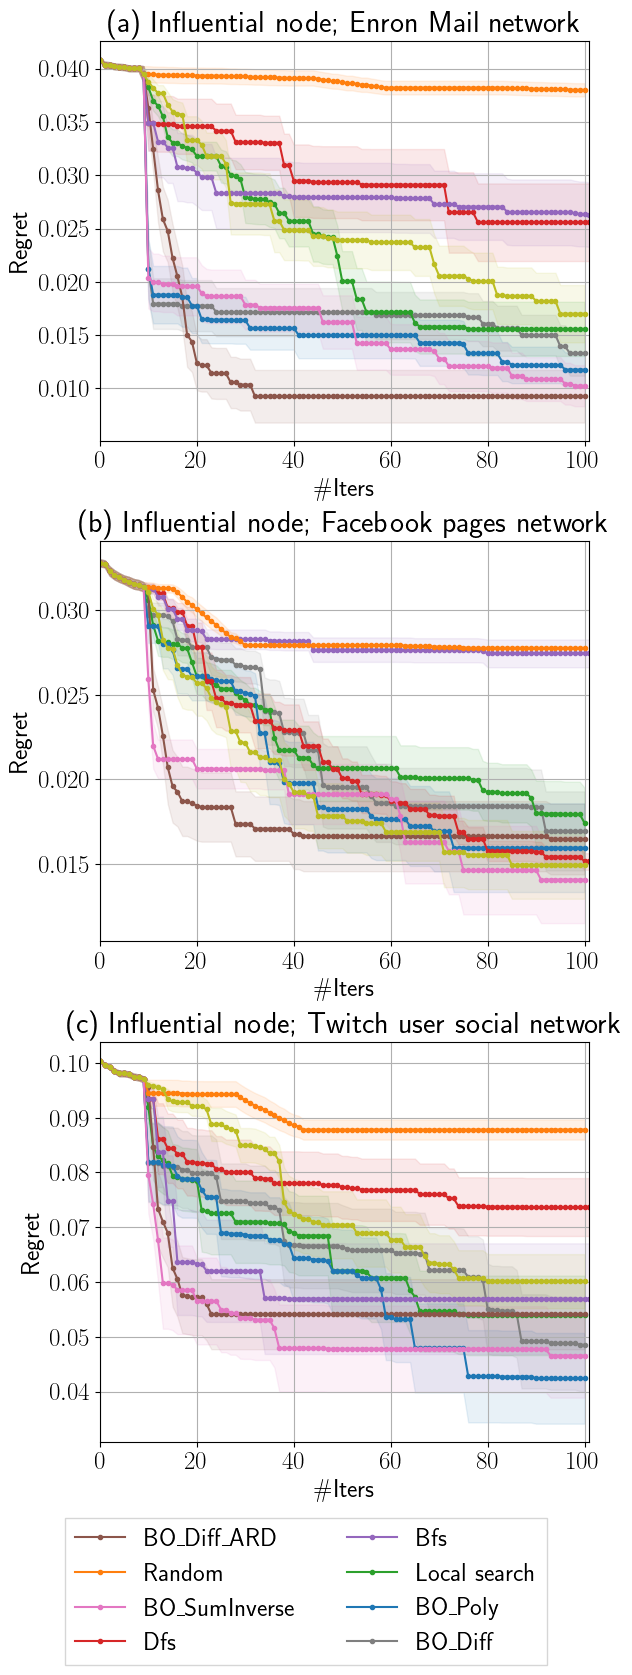

In [10]:
plt.rcParams['text.usetex'] = True
list_experiences = ["real_enron_degree_centrality_contextnodes-100_n_init-20", "real_fb_degree_centrality_contextnodes-100_n_init-20", "real_twitch_degree_centrality_contextnodes-100_n_init-20"]
n_rows, n_cols = 3, 1
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(6, 15))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_row], "./logs/centrality/", list_experiences[i], std=False)

handles, labels = axs[idx_row].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0].title.set_text('(a) Influential node; Enron Mail network')
#axs[0, 0].set_yscale("log")
axs[1].title.set_text('(b) Influential node; Facebook pages network')
#axs[0, 1].set_yscale("log")
axs[2].title.set_text('(c) Influential node; Twitch user social network')
#axs[0, 2].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=2)
#plt.legend()
#plt.show()
plt.savefig("centrality_real_rows.pdf", bbox_inches='tight')

0 0
0 1
0 2


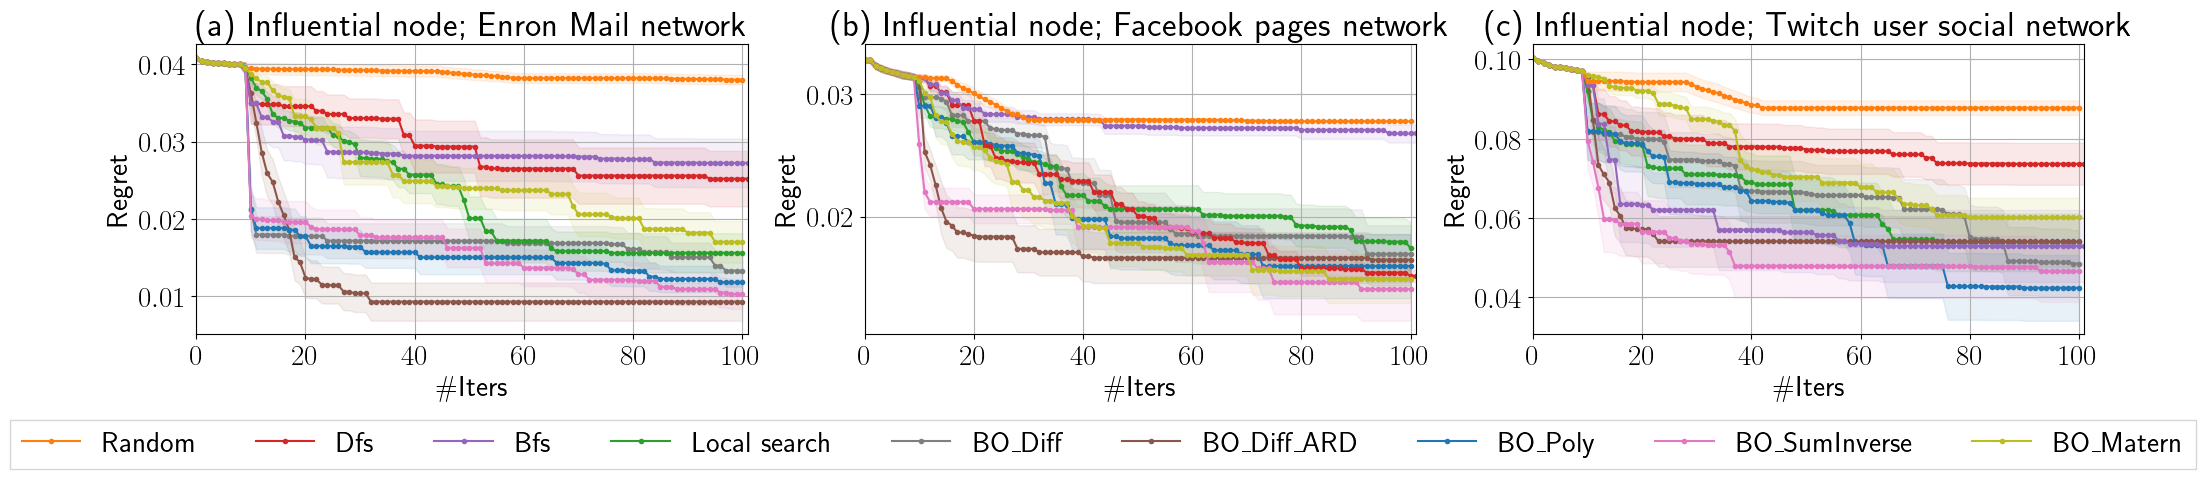

In [14]:
matplotlib.rcParams.update({'font.size': 21})
plt.rcParams['text.usetex'] = True
list_experiences = ["real_enron_degree_centrality_contextnodes-100_n_init-20", "real_fb_degree_centrality_contextnodes-100_n_init-20", "real_twitch_degree_centrality_contextnodes-100_n_init-20"]
n_rows, n_cols = 1, 3
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 4))
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(6, 15))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_col], "./logs/centrality/", list_experiences[i], std=False)

handles, labels = axs[idx_row].get_legend_handles_labels()
change_labels = [6, 4, 5, 1, 0, 2, 3, 7, 8]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0].title.set_text('(a) Influential node; Enron Mail network')
#axs[0, 0].set_yscale("log")
axs[1].title.set_text('(b) Influential node; Facebook pages network')
#axs[0, 1].set_yscale("log")
axs[2].title.set_text('(c) Influential node; Twitch user social network')
#axs[0, 2].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9)
#plt.legend()
#plt.show()
plt.savefig("centrality_real_row.pdf", bbox_inches='tight')

## Centrality with matern

0 0
0 1
0 2
1 0
1 1
1 2


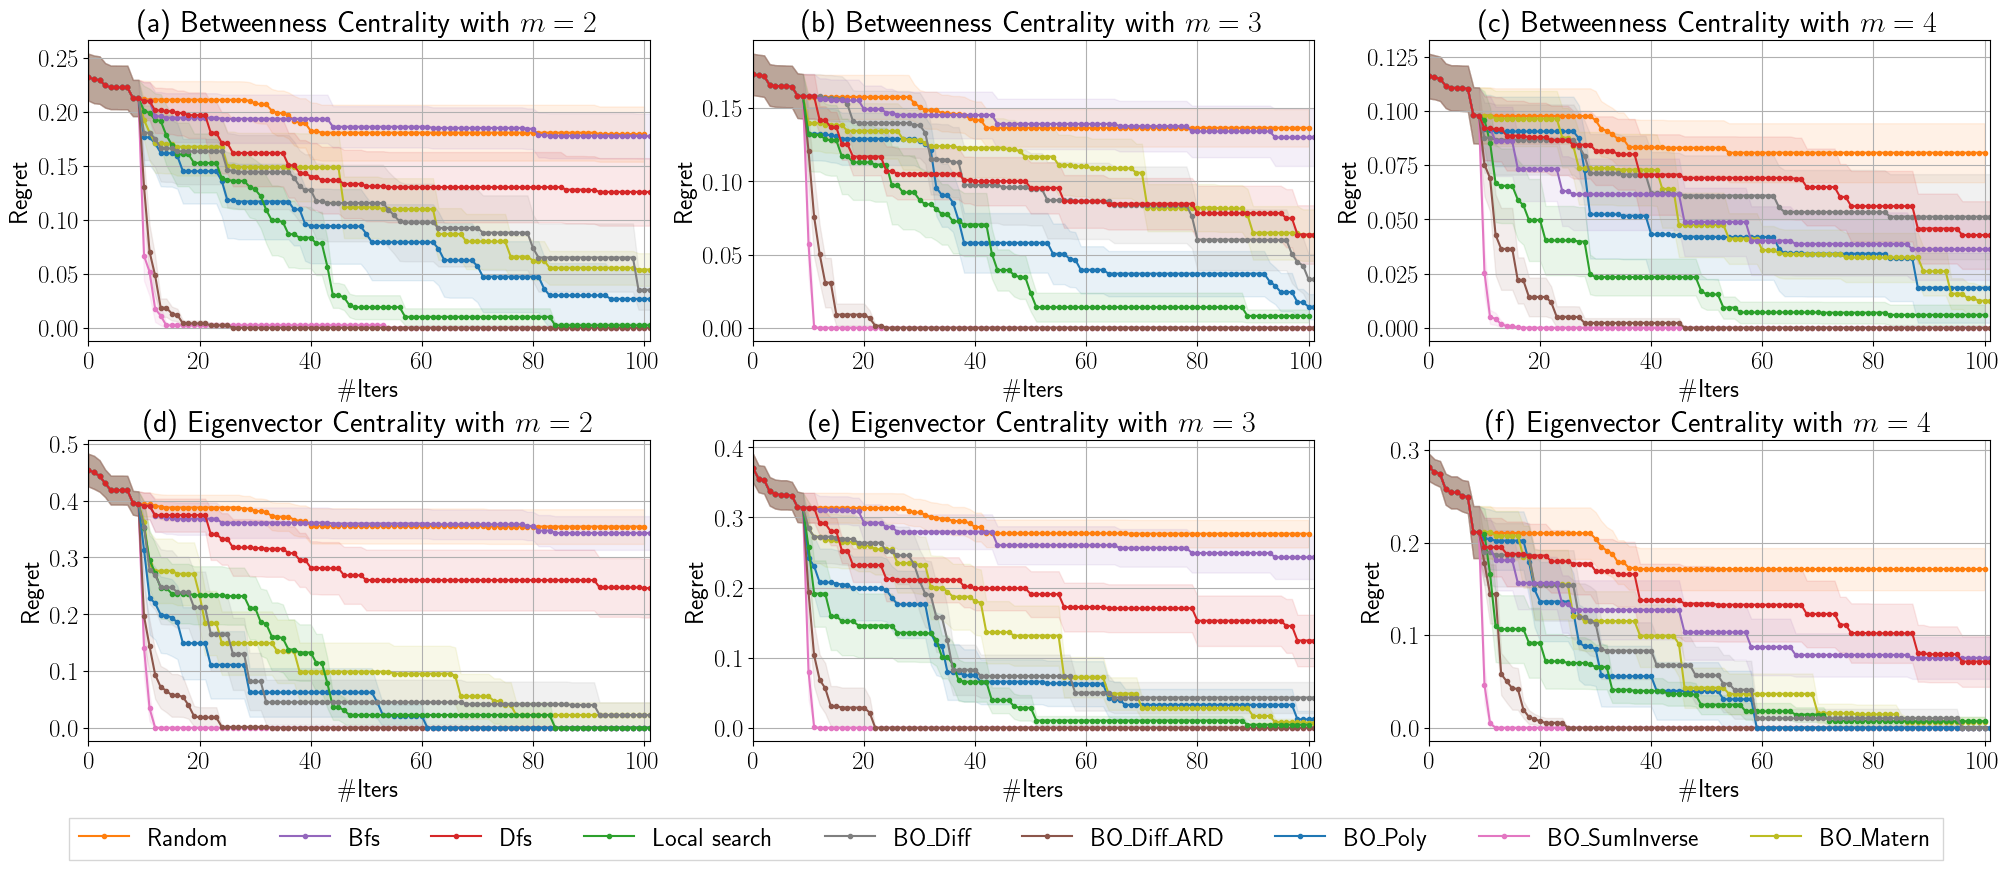

In [12]:
plt.rcParams['text.usetex'] = True
list_experiences = ["ba_betweenness_m-2_ninit-20_n-1000", "ba_betweenness_m-3_ninit-20_n-1000", "ba_betweenness_m-4_ninit-20_n-1000",
                    "ba_eigenvector_centrality_m-2_ninit-20_n-1000", "ba_eigenvector_centrality_m-3_ninit-20_n-1000", "ba_eigenvector_centrality_m-4_ninit-20_n-1000"]
n_rows, n_cols = 2, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_row, idx_col], "./logs/centrality_matern/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [2, 7, 8, 5, 6, 1, 3, 0, 4]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
axs[0, 0].title.set_text('(a) Betweenness Centrality with ' + r'$m = 2$')
axs[0, 1].title.set_text('(b) Betweenness Centrality with ' + r'$m = 3$')
axs[0, 2].title.set_text('(c) Betweenness Centrality with ' + r'$m = 4$')
axs[1, 0].title.set_text('(d) Eigenvector Centrality with ' + r'$m = 2$')
axs[1, 1].title.set_text('(e) Eigenvector Centrality with ' + r'$m = 3$')
axs[1, 2].title.set_text('(f) Eigenvector Centrality with ' + r'$m = 4$')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9)
#plt.legend()
#plt.show()
plt.savefig("centrality_ba_matern.pdf", bbox_inches='tight')

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3


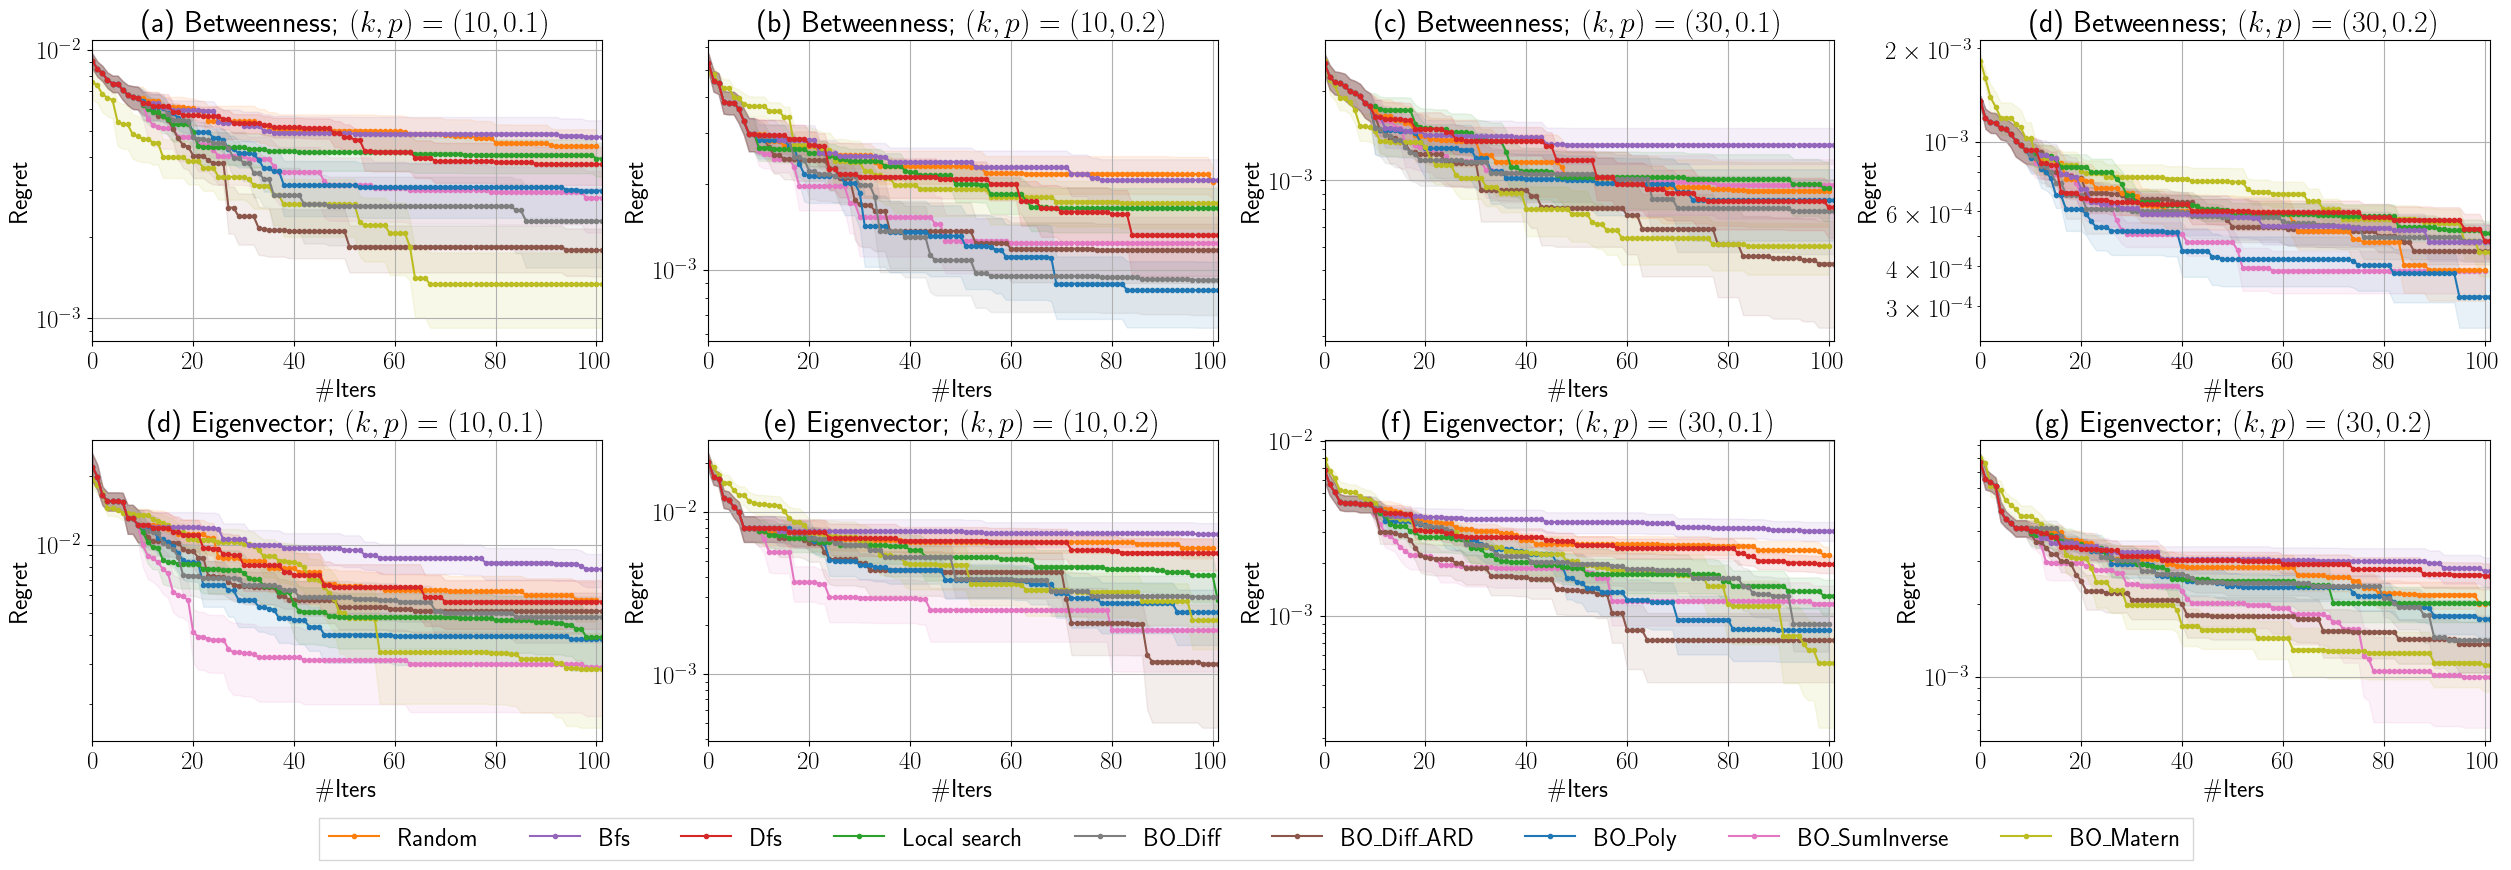

In [9]:
plt.rcParams['text.usetex'] = True
list_experiences = ["ws_betweenness_k-10_p-0.1_ninit-20_n-2000", "ws_betweenness_k-10_p-0.2_ninit-20_n-2000", "ws_betweenness_k-30_p-0.1_ninit-20_n-2000", "ws_betweenness_k-30_p-0.2_ninit-20_n-2000",
                    "ws_eigenvector_centrality_k-10_p-0.1_ninit-20_n-2000", "ws_eigenvector_centrality_k-10_p-0.2_ninit-20_n-2000", "ws_eigenvector_centrality_k-30_p-0.1_ninit-20_n-2000", "ws_eigenvector_centrality_k-30_p-0.2_ninit-20_n-2000"]

n_rows, n_cols = 2, 4
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(25, 8))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_row, idx_col], "./logs/centrality_matern/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [2, 7, 8, 5, 6, 1, 3, 0, 4]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
axs[0, 0].title.set_text('(a) Betweenness; ' + r'$(k, p)=(10, 0.1)$')
axs[0, 0].set_yscale("log")
axs[0, 1].title.set_text('(b) Betweenness; ' + r'$(k, p)=(10, 0.2)$')
axs[0, 1].set_yscale("log")
axs[0, 2].title.set_text('(c) Betweenness; ' + r'$(k, p)=(30, 0.1)$')
axs[0, 2].set_yscale("log")
axs[0, 3].title.set_text('(d) Betweenness; ' + r'$(k, p)=(30, 0.2)$')
axs[0, 3].set_yscale("log")
axs[1, 0].title.set_text('(d) Eigenvector; ' + r'$(k, p)=(10, 0.1)$')
axs[1, 0].set_yscale("log")
axs[1, 1].title.set_text('(e) Eigenvector; ' + r'$(k, p)=(10, 0.2)$')
axs[1, 1].set_yscale("log")
axs[1, 2].title.set_text('(f) Eigenvector; ' + r'$(k, p)=(30, 0.1)$')
axs[1, 2].set_yscale("log")
axs[1, 3].title.set_text('(g) Eigenvector; ' + r'$(k, p)=(30, 0.2)$')
axs[1, 3].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9)
#plt.legend()
#plt.show()
plt.savefig("centrality_ws_matern.pdf", bbox_inches='tight')

0 0
0 1
0 2
0 3
0 4
0 5
0 6
1 0
1 1
1 2
1 3
1 4
1 5
1 6


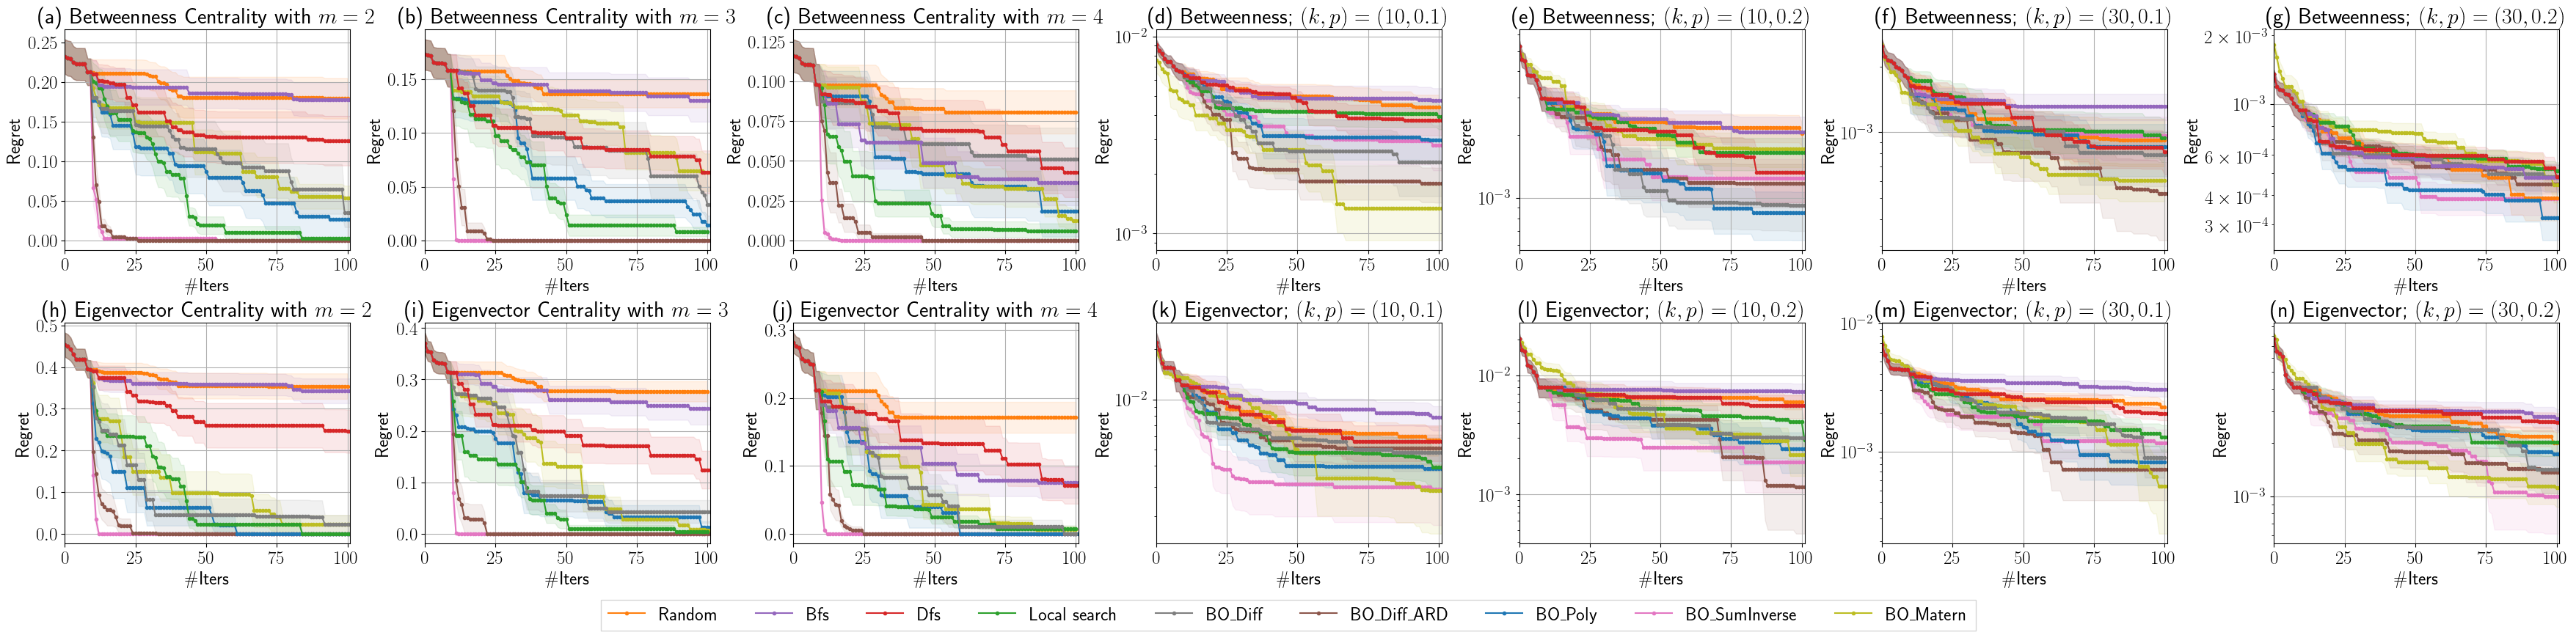

In [15]:
plt.rcParams['text.usetex'] = True
list_experiences = ["ba_betweenness_m-2_ninit-20_n-1000", "ba_betweenness_m-3_ninit-20_n-1000", "ba_betweenness_m-4_ninit-20_n-1000", "ws_betweenness_k-10_p-0.1_ninit-20_n-2000", "ws_betweenness_k-10_p-0.2_ninit-20_n-2000", "ws_betweenness_k-30_p-0.1_ninit-20_n-2000", "ws_betweenness_k-30_p-0.2_ninit-20_n-2000",
                    "ba_eigenvector_centrality_m-2_ninit-20_n-1000", "ba_eigenvector_centrality_m-3_ninit-20_n-1000", "ba_eigenvector_centrality_m-4_ninit-20_n-1000", "ws_eigenvector_centrality_k-10_p-0.1_ninit-20_n-2000", "ws_eigenvector_centrality_k-10_p-0.2_ninit-20_n-2000", "ws_eigenvector_centrality_k-30_p-0.1_ninit-20_n-2000", "ws_eigenvector_centrality_k-30_p-0.2_ninit-20_n-2000"]
n_rows, n_cols = 2, 7
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(35, 8))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_row, idx_col], "./logs/centrality_matern/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [2, 7, 8, 5, 6, 1, 3, 0, 4]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
axs[0, 0].title.set_text('(a) Betweenness Centrality with ' + r'$m = 2$')
axs[0, 1].title.set_text('(b) Betweenness Centrality with ' + r'$m = 3$')
axs[0, 2].title.set_text('(c) Betweenness Centrality with ' + r'$m = 4$')
axs[1, 0].title.set_text('(h) Eigenvector Centrality with ' + r'$m = 2$')
axs[1, 1].title.set_text('(i) Eigenvector Centrality with ' + r'$m = 3$')
axs[1, 2].title.set_text('(j) Eigenvector Centrality with ' + r'$m = 4$')

axs[0, 3].title.set_text('(d) Betweenness; ' + r'$(k, p)=(10, 0.1)$')
axs[0, 3].set_yscale("log")
axs[0, 4].title.set_text('(e) Betweenness; ' + r'$(k, p)=(10, 0.2)$')
axs[0, 4].set_yscale("log")
axs[0, 5].title.set_text('(f) Betweenness; ' + r'$(k, p)=(30, 0.1)$')
axs[0, 5].set_yscale("log")
axs[0, 6].title.set_text('(g) Betweenness; ' + r'$(k, p)=(30, 0.2)$')
axs[0, 6].set_yscale("log")
axs[1, 3].title.set_text('(k) Eigenvector; ' + r'$(k, p)=(10, 0.1)$')
axs[1, 3].set_yscale("log")
axs[1, 4].title.set_text('(l) Eigenvector; ' + r'$(k, p)=(10, 0.2)$')
axs[1, 4].set_yscale("log")
axs[1, 5].title.set_text('(m) Eigenvector; ' + r'$(k, p)=(30, 0.1)$')
axs[1, 5].set_yscale("log")
axs[1, 6].title.set_text('(n) Eigenvector; ' + r'$(k, p)=(30, 0.2)$')
axs[1, 6].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9)
#plt.legend()
#plt.show()
plt.savefig("centrality_ws_matern_complete.pdf", bbox_inches='tight')

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3


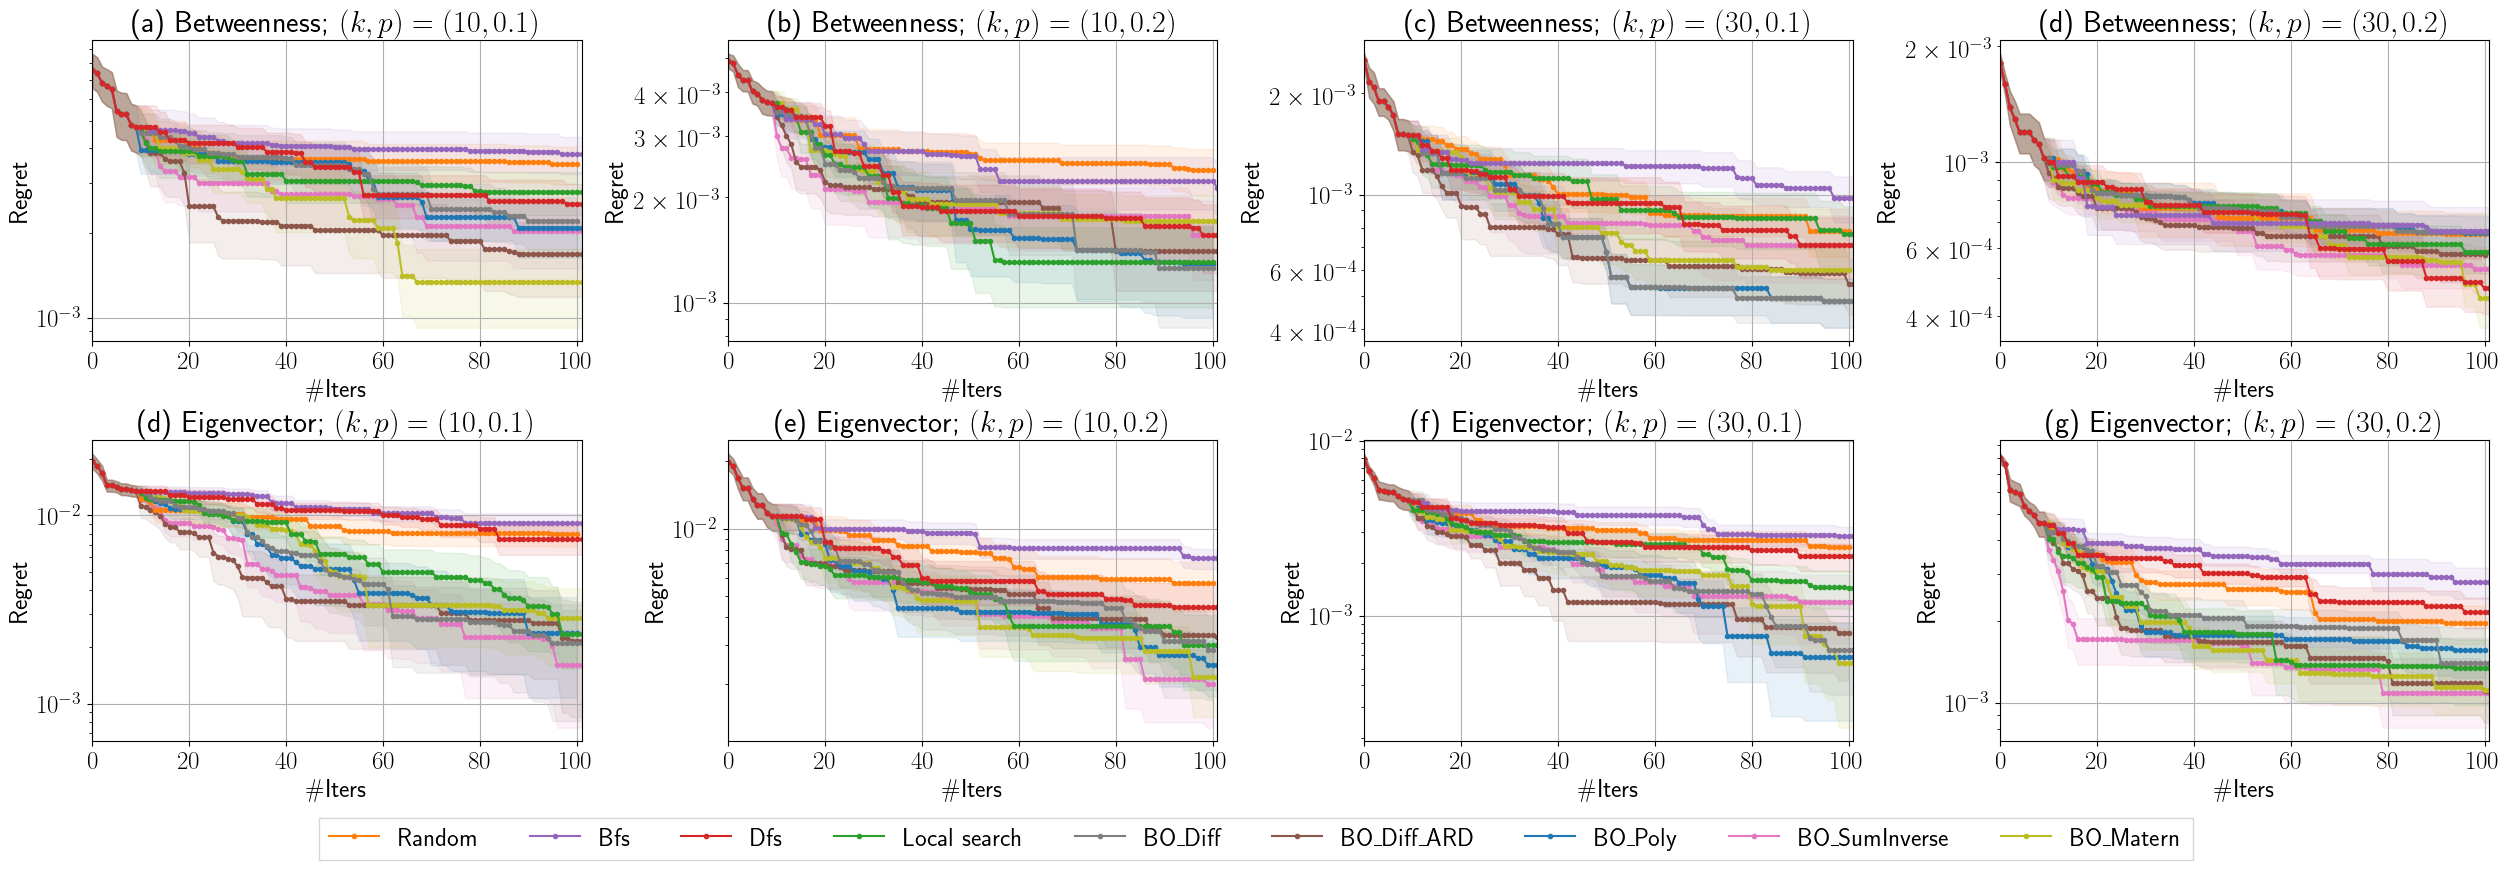

In [7]:
list_experiences = ["ws_betweenness_k-10_p-0.1_ninit-20_n-2000", "ws_betweenness_k-10_p-0.2_ninit-20_n-2000", "ws_betweenness_k-30_p-0.1_ninit-20_n-2000", "ws_betweenness_k-30_p-0.2_ninit-20_n-2000",
                    "ws_eigenvector_centrality_k-10_p-0.1_ninit-20_n-2000", "ws_eigenvector_centrality_k-10_p-0.2_ninit-20_n-2000", "ws_eigenvector_centrality_k-30_p-0.1_ninit-20_n-2000", "ws_eigenvector_centrality_k-30_p-0.2_ninit-20_n-2000"]
n_rows, n_cols = 2, 4
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(25, 8))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_row, idx_col], "./logs/centrality_matern/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [2, 7, 8, 5, 6, 1, 3, 0, 4]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('(a) Betweenness; ' + r'$(k, p)=(10, 0.1)$')
axs[0, 0].set_yscale("log")
axs[0, 1].title.set_text('(b) Betweenness; ' + r'$(k, p)=(10, 0.2)$')
axs[0, 1].set_yscale("log")
axs[0, 2].title.set_text('(c) Betweenness; ' + r'$(k, p)=(30, 0.1)$')
axs[0, 2].set_yscale("log")
axs[0, 3].title.set_text('(d) Betweenness; ' + r'$(k, p)=(30, 0.2)$')
axs[0, 3].set_yscale("log")
axs[1, 0].title.set_text('(d) Eigenvector; ' + r'$(k, p)=(10, 0.1)$')
axs[1, 0].set_yscale("log")
axs[1, 1].title.set_text('(e) Eigenvector; ' + r'$(k, p)=(10, 0.2)$')
axs[1, 1].set_yscale("log")
axs[1, 2].title.set_text('(f) Eigenvector; ' + r'$(k, p)=(30, 0.1)$')
axs[1, 2].set_yscale("log")
axs[1, 3].title.set_text('(g) Eigenvector; ' + r'$(k, p)=(30, 0.2)$')
axs[1, 3].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9)
#plt.legend()
plt.show()
#plt.savefig("centrality_ws.pdf", bbox_inches='tight')

## Eval query testfunction

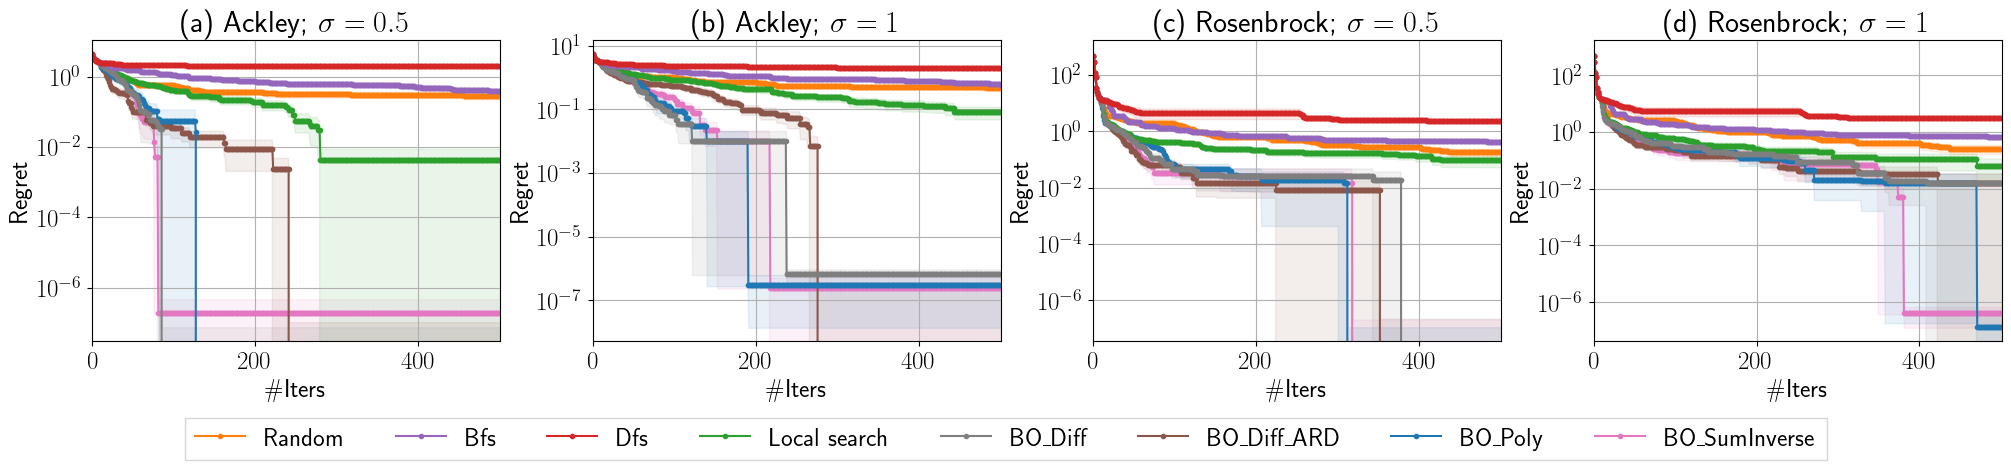

In [7]:
plt.rcParams['text.usetex'] = True
list_experiences = ["ackley_noise-0.5_n-1000", "ackley_noise-1.0_n-1000",
                    "rosenbrock_noise-0.5_n-1000", "rosenbrock_noise-1.0_n-1000"]
n_rows, n_cols = 1, 4
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 4))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    plot_result(axs[idx_col], "./logs/eval_query/", list_experiences[i], std=False)

handles, labels = axs[idx_col].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0].title.set_text('(a) Ackley; ' + r'$\sigma = 0.5$')
axs[0].set_yscale("log")
axs[1].title.set_text('(b) Ackley; ' + r'$\sigma = 1$')
axs[1].set_yscale("log")
axs[2].title.set_text('(c) Rosenbrock; ' + r'$\sigma = 0.5$')
axs[2].set_yscale("log")
axs[3].title.set_text('(d) Rosenbrock; ' + r'$\sigma = 1$')
axs[3].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
#plt.show()
plt.savefig("test_function_row_eval.pdf", bbox_inches='tight')

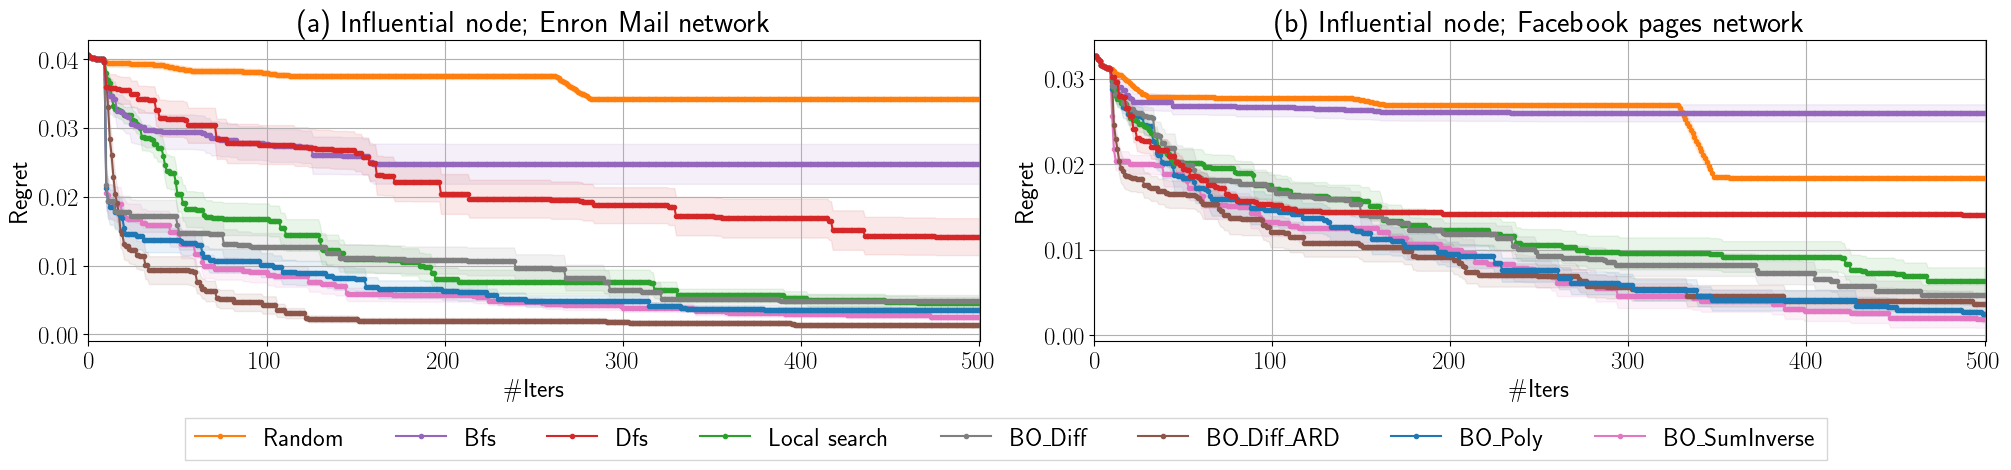

In [9]:
plt.rcParams['text.usetex'] = True
list_experiences = ["real_enron_degree_centrality_contextnodes-100_n_init-20", "real_fb_degree_centrality_contextnodes-100_n_init-20"]
n_rows, n_cols = 1, 2
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 4))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    plot_result(axs[idx_col], "./logs/eval_query/", list_experiences[i], std=False)

handles, labels = axs[idx_col].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0].title.set_text('(a) Influential node; Enron Mail network')
axs[1].title.set_text('(b) Influential node; Facebook pages network')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
#plt.show()
plt.savefig("centrality_real_eval.pdf", bbox_inches='tight')

### Plot large graph size 

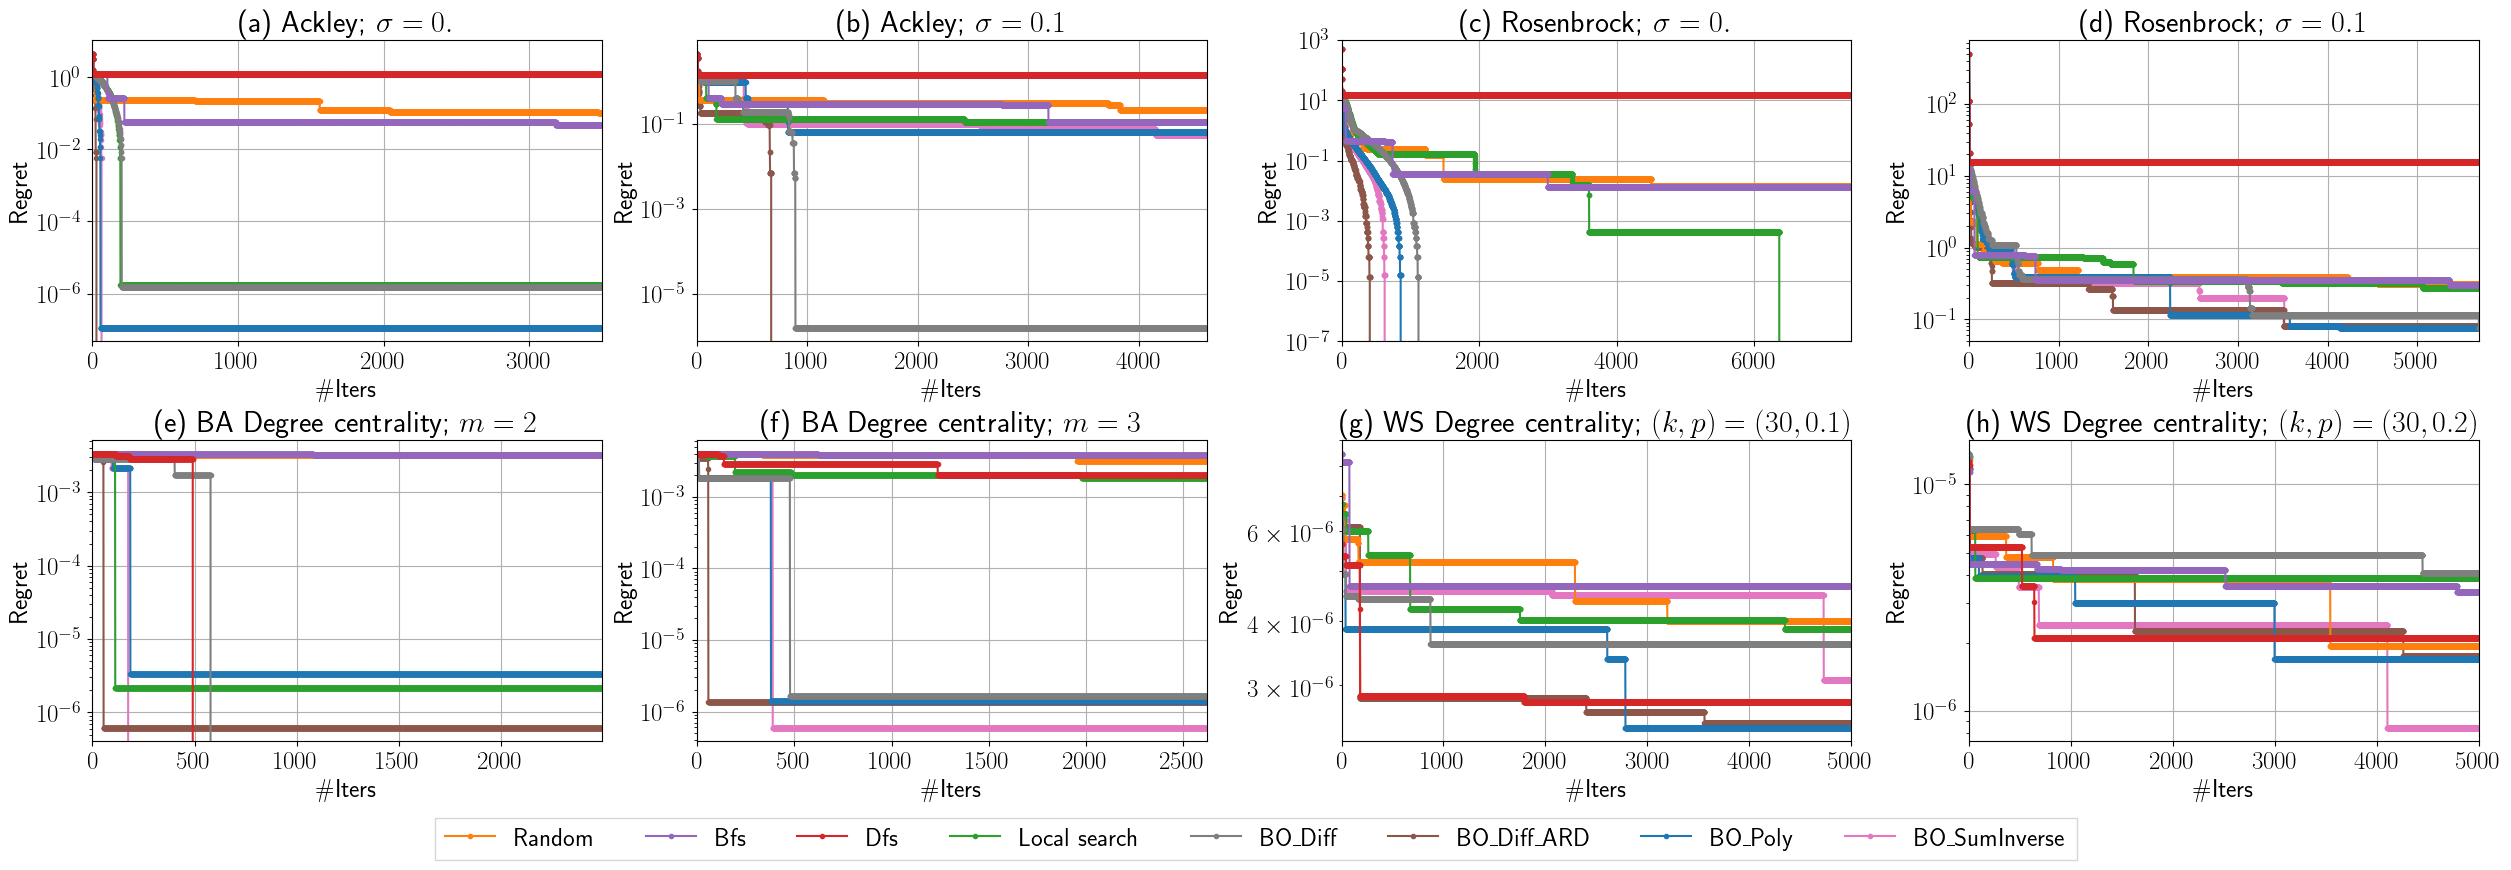

In [11]:
plt.rcParams['text.usetex'] = True
list_experiences = ["ackley_noise-0.0_n-1000000", "ackley_noise-0.1_n-1000000", "rosenbrock_noise-0.0_n-1000000", "rosenbrock_noise-0.1_n-1000000",
                    "ba_degree_centrality_m-2_ninit-20_n-1000000_contextnodes-200", "ba_degree_centrality_m-3_ninit-20_n-1000000_contextnodes-200", "ws_degree_centrality_k-30_p-0.1_ninit-20_n-1000000_contextnodes-200", "ws_degree_centrality_k-30_p-0.2_ninit-20_n-1000000_contextnodes-200"]
n_rows, n_cols = 2, 4
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(25, 8))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    plot_result(axs[idx_row,idx_col], "./logs/large_graph/", list_experiences[i], std=False)

handles, labels = axs[idx_row,idx_col].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0,0].title.set_text('(a) Ackley; ' + r'$\sigma = 0.$')
axs[0,0].set_yscale("log")
axs[0,1].title.set_text('(b) Ackley; ' + r'$\sigma = 0.1$')
axs[0,1].set_yscale("log")
axs[0,2].title.set_text('(c) Rosenbrock; ' + r'$\sigma = 0.$')
axs[0,2].set_yscale("log")
axs[0,2].set_ylim(1e-7, 1000)
axs[0,3].title.set_text('(d) Rosenbrock; ' + r'$\sigma = 0.1$')
axs[0,3].set_yscale("log")

axs[1,0].title.set_text('(e) BA Degree centrality; ' + r'$m=2$')
axs[1,0].set_yscale("log")
axs[1,1].title.set_text('(f) BA Degree centrality; ' + r'$m=3$')
axs[1,1].set_yscale("log")
axs[1,2].title.set_text('(g) WS Degree centrality; ' + r'$(k, p)=(30, 0.1)$')
axs[1,2].set_yscale("log")
axs[1,3].title.set_text('(h) WS Degree centrality; ' + r'$(k, p)=(30, 0.2)$')
axs[1,3].set_yscale("log")
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
#plt.show()
plt.savefig("large_graph.pdf", bbox_inches='tight')

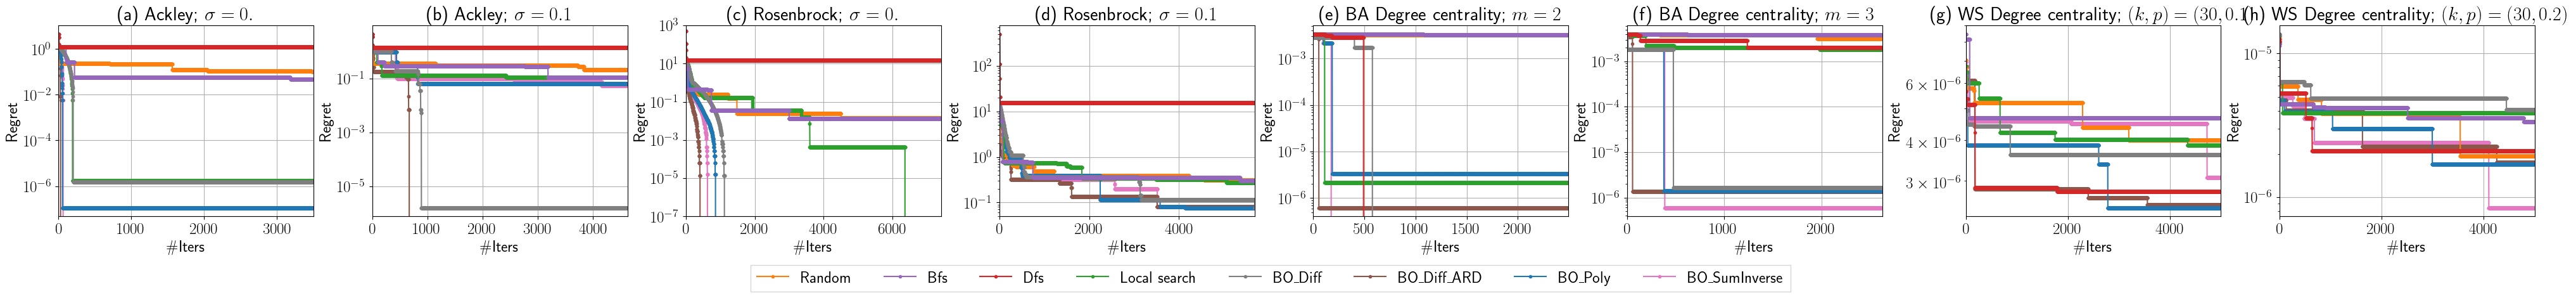

In [17]:
plt.rcParams['text.usetex'] = True
list_experiences = ["ackley_noise-0.0_n-1000000", "ackley_noise-0.1_n-1000000", "rosenbrock_noise-0.0_n-1000000", "rosenbrock_noise-0.1_n-1000000",
                    "ba_degree_centrality_m-2_ninit-20_n-1000000_contextnodes-200", "ba_degree_centrality_m-3_ninit-20_n-1000000_contextnodes-200", "ws_degree_centrality_k-30_p-0.1_ninit-20_n-1000000_contextnodes-200", "ws_degree_centrality_k-30_p-0.2_ninit-20_n-1000000_contextnodes-200"]
n_rows, n_cols = 1, 8
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(40, 4))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    plot_result(axs[idx_col], "./logs/large_graph/", list_experiences[i], std=False)

handles, labels = axs[idx_col].get_legend_handles_labels()
change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
axs[0].title.set_text('(a) Ackley; ' + r'$\sigma = 0.$')
axs[0].set_yscale("log")
axs[1].title.set_text('(b) Ackley; ' + r'$\sigma = 0.1$')
axs[1].set_yscale("log")
axs[2].title.set_text('(c) Rosenbrock; ' + r'$\sigma = 0.$')
axs[2].set_yscale("log")
axs[2].set_ylim(1e-7, 1000)
axs[3].title.set_text('(d) Rosenbrock; ' + r'$\sigma = 0.1$')
axs[3].set_yscale("log")

axs[4].title.set_text('(e) BA Degree centrality; ' + r'$m=2$')
axs[4].set_yscale("log")
axs[5].title.set_text('(f) BA Degree centrality; ' + r'$m=3$')
axs[5].set_yscale("log")
axs[6].title.set_text('(g) WS Degree centrality; ' + r'$(k, p)=(30, 0.1)$')
axs[6].set_yscale("log")
axs[7].title.set_text('(h) WS Degree centrality; ' + r'$(k, p)=(30, 0.2)$')
axs[7].set_yscale("log")
#axs, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
#plt.show()
plt.savefig("large_graph.pdf", bbox_inches='tight')